# Understanding personal protective behaviours and opportunities for interventions:
## Results from a multi-method investigation of cross-sectional data
#### Kaisa Sauro, James Twose, Gjalt-Jorn Peters, Matti Heino & Nelli Hankonen

## approach used here: _CatBoost Regression_

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import session_info

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, GroupKFold, GroupShuffleSplit, RepeatedStratifiedKFold, RepeatedKFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_validate
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.model_selection import KFold
import pingouin as pg
from catboost import CatBoostRegressor, Pool
# import xgboost
import shap
shap.initjs()

/opt/miniconda3/envs/ds_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if "jms_style_sheet" in plt.style.available:
    plt.style.use("jms_style_sheet")

# _ = sns.set_style("whitegrid")

### Virtual Environments and Packages

In [3]:
session_info.show(req_file_name="notebook-requirements.txt",
      write_req_file=True) #add write_req_file=True to function to get requirements.txt file of packages used

### Read in data, show info and data head

In [4]:
df = pd.read_csv("data/shield_gjames_21-09-20_prepped.csv").drop("Unnamed: 0", axis=1)

In [5]:
df.head()

id  sampling_weight  demographic_gender demographic_age  \
0   1         2.060959                   2             60+   
1   2         1.784139                   2           40-49   
2   3         1.204000                   1             60+   
3   4         2.232220                   1             60+   
4   5         1.627940                   2           18-29   

   demographic_4_areas  demographic_8_areas  demographic_higher_education  \
0                    2                    7                             0   
1                    1                    1                             1   
2                    1                    2                             1   
3                    2                    6                             0   
4                    1                    3                             0   

   behaviour_indoors_nonhouseholders  behaviour_close_contact  \
0                                  2                        5   
1                                  3                        3   
2                                  4                        4   
3                                  4                        3   
4                                  6                        3   

   behaviour_quarantined  ...  intention_public_transport_recoded  \
0                      2  ...                                   0   
1                      2  ...                                   0   
2                      2  ...                                   0   
3                      2  ...                                   0   
4                      2  ...                                   0   

   intention_indoor_meeting_recoded  intention_restaurant_recoded  \
0                                 0                             0   
1                                 1                             1   
2                                 0                             0   
3                                 2                             0   
4                                 2                             0   

   intention_pa_recoded  intention_composite  \
0                     0                    0   
1                     1                    3   
2                     0                    0   
3                     2                    4   
4                     0                    2   

   behaviour_indoors_nonhouseholders_recoded  behaviour_unmasked_recoded  \
0                                   1.000000                    0.000000   
1                                   0.785714                    0.214286   
2                                   0.500000                    0.214286   
3                                   0.500000                    0.500000   
4                                   0.000000                    0.214286   

   behavior_composite  behavior_composite_recoded  \
0            0.000000                    0.000000   
1            0.168367                    0.841837   
2            0.107143                    0.535714   
3            0.250000                    1.250000   
4            0.000000                    0.000000   

   intention_behavior_composite  
0                      0.000000  
1                      1.920918  
2                      0.267857  
3                      2.625000  
4                      1.000000  

[5 rows x 106 columns]

In [6]:
sdt_columns = df.filter(regex="sdt").columns.tolist()

In [7]:
drop_sdt = True
if drop_sdt:
    df=df.drop(sdt_columns, axis=1)

In [8]:
df.shape

(2272, 87)

### Specify the feature list, grouping variable, and specify the grouping variable as a categorical variable

In [9]:
target = "intention_behavior_composite"

In [10]:
df[target] = (df[target] - 10) * -1

In [11]:
features_list = df.filter(regex="^automaticity|attitude|^norms|^risk|^effective").columns.tolist()

In [12]:
meta_columns = ['Original position', 'Variable name', 'Label',
       'Item english translation ', 'Label short', 'Type', 'New variable name',
       'variable name helper',
       'Of primary interest as a predictor (i.e. feature)?', 'English lo-anchor',
       'English hi-anchor']

In [13]:
sheet_id = "1BEX4W8XRGnuDk4Asa_pdKij3EIZBvhSPqHxFrDjM07k"
sheet_name = "Variable_names"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
meta_df = pd.read_csv(url).loc[:, meta_columns]

In [14]:
# pd.set_option("display.max_colwidth", 350)
# pd.set_option('display.expand_frame_repr', True)
# meta_df[["Item english translation ", "Label short", "New variable name"]] #use Label Short instead of Item english translation for relabelling the axes

In [15]:
# meta_df = pd.read_excel("metadata/questionLabels.xlsx").loc[:, meta_columns]

In [16]:
meta_list = df.filter(regex="^automaticity|attitude|^norms|^risk|^effective|^behaviour|^intention").columns.tolist()

In [17]:
pd.set_option("display.max_colwidth", 350)
pd.set_option('display.expand_frame_repr', True)
meta_df.loc[meta_df["New variable name"].isin(meta_list), ["Item english translation ", "Label short", "New variable name"]] #use Label Short instead of Item english translation for relabelling the axes

Item english translation   \
12                                         How often in the last 7 days have you been indoors with people outside your household so that it is not related to obligations? For example, meeting friends, visiting hobbies, non-essential shopping, or other activities that are not required for your work or other duties.\n    
13                                                                              In the last 7 days, have you been in close contact with people outside your household? Direct contact means spending more than one minute less than two meters away from another person or touching (e.g., shaking hands) outdoors or indoors.   
14                                                                                                                  Are you currently in quarantine or isolation due to an official instruction or order? (For example, because you are waiting for a corona test, have returned from abroad or been exposed to a coronavirus)   
15                                                                                                                                                                                                             How often in the last 7 days were you in your free time without a mask indoors with people you don’t live with?   
24                                                                                                                                                 If in the next 7 days you go to visit the following indoor spaces and there are people outside your household, Are you going to wear a mask? Grocery store or other store\n   
25                                                                                                                                  If in the next 7 days you go to visit the following indoor spaces and there are people outside your household, Are you going to wear a mask? Bus, train or other means of public transport   
26                                                                                                                                  If in the next 7 days you go to visit the following indoor spaces and there are people outside your household, Are you going to wear a mask? Meeting people outside your household indoors   
27                                                                                                                                                If in the next 7 days you go to visit the following indoor spaces and there are people outside your household, Are you going to wear a mask? Cafe, restaurant or bar indoors   
28                                                                                                                                                                If in the next 7 days you go to visit the following indoor spaces and there are people outside your household, Are you going to wear a mask? Indoor exercise   
29                                                                            Taking a mask with you to a store or public transport, for example, has already become automatic for some and is done without thinking. For others, taking a mask with them is not automatic at all, but requires conscious thinking and effort.   
30                                                                                  Putting on a mask, for example in a shop or on public transport, has already become automatic for some and it happens without thinking. For others, putting on a mask is not automatic at all, but requires conscious thinking and effort.   
32                                                                                                                                                                                                               What consequences do you think it has if you use a face mask in your free time? If or when I use a face mask…   
33                                                                                                         

In [18]:
pd.set_option("display.max_colwidth", 100)

## EDA on the target
Check the amount of samples in the target

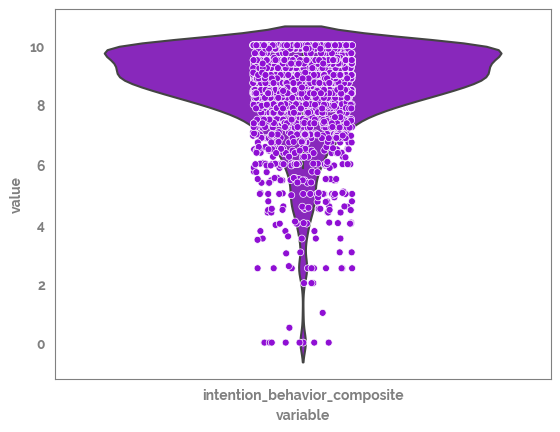

In [19]:
_ = sns.violinplot(data=df[[target]].melt(), 
                    x="variable", 
                    y="value"
               )
_ = sns.stripplot(data=df[[target]].melt(), 
                    x="variable", 
                    y="value",
                  edgecolor='white',
                  linewidth=0.5
               )

In [20]:
pd.crosstab(df["demographic_gender"], df["demographic_age"])

demographic_age     18-29  30-39  40-49  50-59  60+
demographic_gender                                 
1                     114    169    187    168  337
2                     281    185    229    211  391

In [21]:
target_df = df[target]
target_df.describe().to_frame().T

count      mean       std  min       25%  \
intention_behavior_composite  2272.0  8.582428  1.524704 -0.0  8.017857   

                                   50%  75%   max  
intention_behavior_composite  8.964286  9.5  10.0

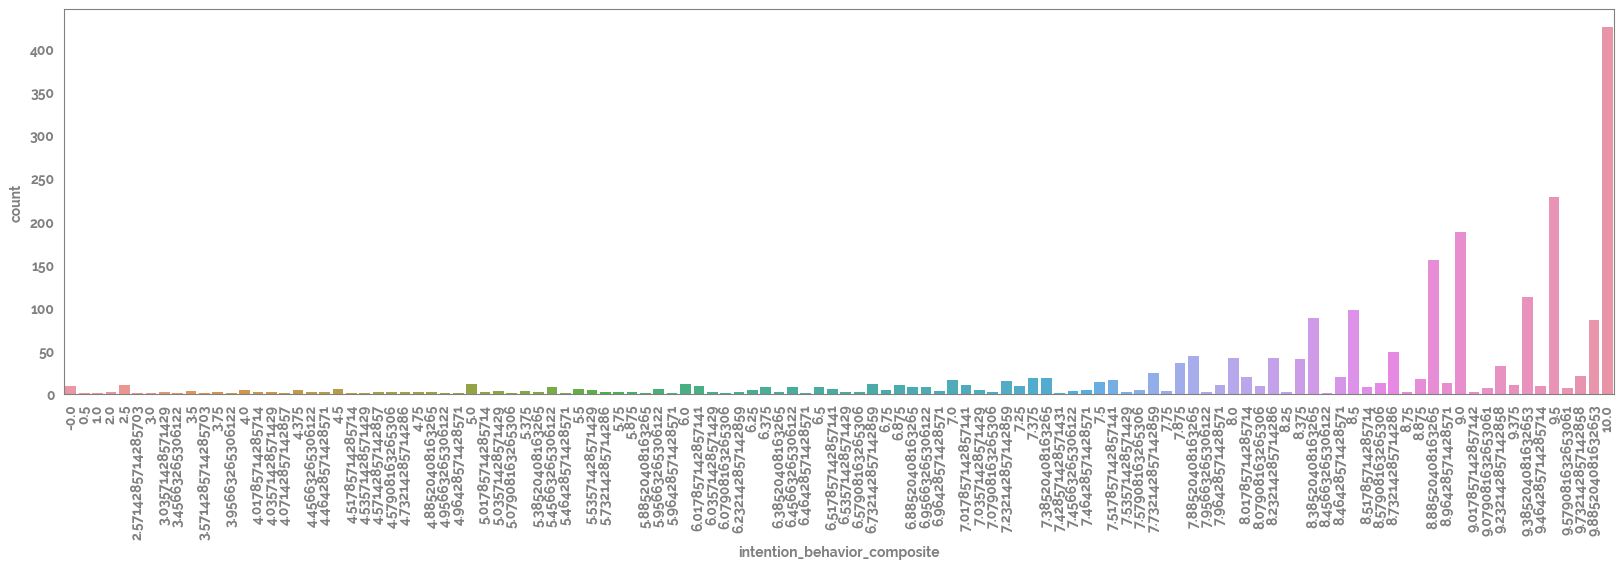

In [22]:
_ = plt.figure(figsize=(20, 5))
_ = sns.countplot(x=target_df)
_ = plt.xticks(rotation=90)

## Force all feature variables to categorical data

In [23]:
df[features_list] = df[features_list].astype("category")

In [24]:
df = (df[["demographic_age", "demographic_higher_education"] + features_list + [target]])

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2272 entries, 0 to 2271
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   demographic_age                   2272 non-null   object  
 1   demographic_higher_education      2272 non-null   int64   
 2   automaticity_carry_mask           2272 non-null   category
 3   automaticity_put_on_mask          2272 non-null   category
 4   inst_attitude_protects_self       2272 non-null   category
 5   inst_attitude_protects_others     2272 non-null   category
 6   inst_attitude_sense_of_community  2272 non-null   category
 7   inst_attitude_enough_oxygen       2272 non-null   category
 8   inst_attitude_no_needless_waste   2272 non-null   category
 9   norms_family_friends              2272 non-null   category
 10  norms_risk_groups                 2272 non-null   category
 11  norms_officials                   2272 non-null   catego

In [26]:
grouping_var = target

In [27]:
display(df[grouping_var].value_counts().head().to_frame()), df.shape[0], df[grouping_var].value_counts().head().sum()

intention_behavior_composite
10.000000                           424
9.500000                            228
9.000000                            187
8.885204                            155
9.385204                            112

(None, 2272, 1106)

In [28]:
def naive_catboost_forest_summary(df: pd.DataFrame,
                                 grouping_var: str,
                                 column_list: list,
                                  plot_title: str
                                 ):
    y = df[grouping_var]
    X = df[column_list]

    feature_plot, ax = plt.subplots(figsize=(10,7))
    _ = sns.boxplot(ax=ax, 
                    data=X.apply(lambda x: x.cat.codes), 
                    orient="v", 
                   )
    _ = plt.title(f'Feature Distributions {plot_title}')
    _ = plt.setp(ax.get_xticklabels(), rotation=90)
    _ = plt.grid()
    _ = plt.tight_layout()
    _ = plt.show()

    model = CatBoostRegressor(iterations=500,
                               depth=None,
                               learning_rate=1,
                               loss_function='RMSE',
                               verbose=False)

    # train the model
    _ = model.fit(X, y, cat_features=column_list)

    # create dataframe with importances per feature
    feature_importance = pd.Series(dict(zip(column_list, model.feature_importances_.round(2)))) 

    feature_importance_df = pd.DataFrame(feature_importance.sort_values(ascending=False)).reset_index().rename(columns={"index": "feature", 0: "feature_importance"})

    _ = plt.figure(figsize=(7, 7))
    gini_plot = sns.barplot(data=feature_importance_df, 
                            x="feature_importance", 
                            y="feature")
    _ = plt.title(f'Feature Importance {plot_title}')
    _ = plt.show()

    shap_values = model.get_feature_importance(Pool(X, label=y,cat_features=X.columns.tolist()), type="ShapValues")

    shap_values = shap_values[:,:-1]

    _ = shap.summary_plot(shap_values, 
                                  X.astype(int), 
                                  feature_names=X.columns, 
                                  max_display=X.shape[1],
                                 show=False,
                         title=plot_title) 
    shap_plot = plt.gca()
    
    tmp_actual = (X
     .melt(value_name='actual_value')
    )

    tmp_shap = (pd.DataFrame(shap_values, columns=column_list)
     .melt(value_name='shap_value')
    )

    shap_actual_df = pd.concat([tmp_actual, tmp_shap[["shap_value"]]], axis=1)

    
    y_pred = model.predict(X)

    df_test = pd.DataFrame({"y_pred": y_pred, grouping_var: y})

    user_ids_first = df_test.head(1).index.tolist()[0]
    user_ids_last = df_test.tail(1).index.tolist()[0]

    _ = plt.figure(figsize=(30,8))
    _ = plt.title(f"Catboost Regressor(fitted set) | RMSE = {round(np.sqrt(mean_squared_error(df_test['y_pred'], df_test[grouping_var])),4)} | bias Error = {round(np.mean(df_test['y_pred'] - df_test[grouping_var]), 4)} | {plot_title}")
    rmse_plot = plt.stem(df_test.index, df_test['y_pred'] - df_test[grouping_var], use_line_collection=True, linefmt='grey', markerfmt='D')
    _ = plt.hlines(y=round(np.sqrt(mean_squared_error(df_test['y_pred'], df_test[grouping_var])),2), colors='b', linestyles='-.', label='+ RMSE', 
                   xmin = user_ids_first, 
                   xmax = user_ids_last
                  ) 
    _ = plt.hlines(y=round(-np.sqrt(mean_squared_error(df_test['y_pred'], df_test[grouping_var])),2), colors='b', linestyles='-.', label='- RMSE', 
                   xmin = user_ids_first, 
                   xmax = user_ids_last
                  ) 
    _ = plt.xticks(rotation=90, ticks=df_test.index)
    _ = plt.ylabel(f"'Error = y_predicted - {grouping_var}'")
    _ = plt.legend()
    _ = plt.show()
    
    return feature_plot, gini_plot.get_figure(), shap_plot.get_figure(), rmse_plot, feature_importance_df, shap_actual_df

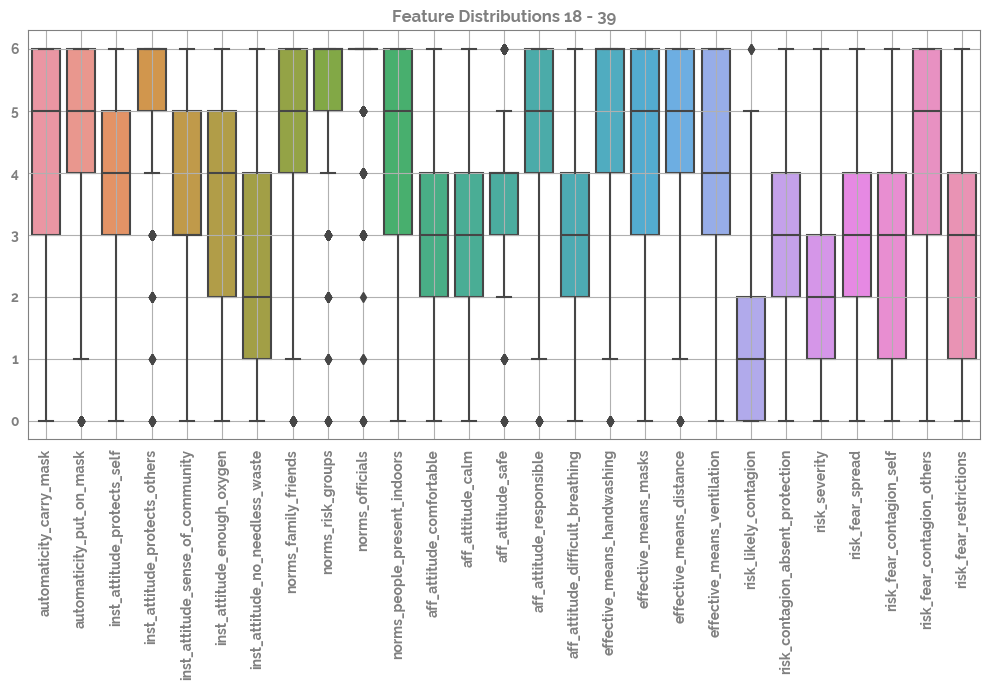

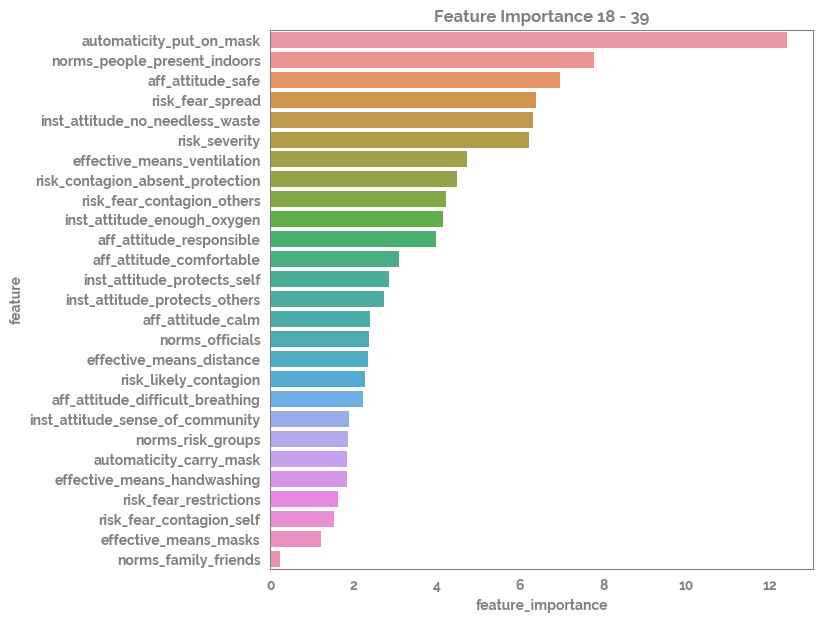

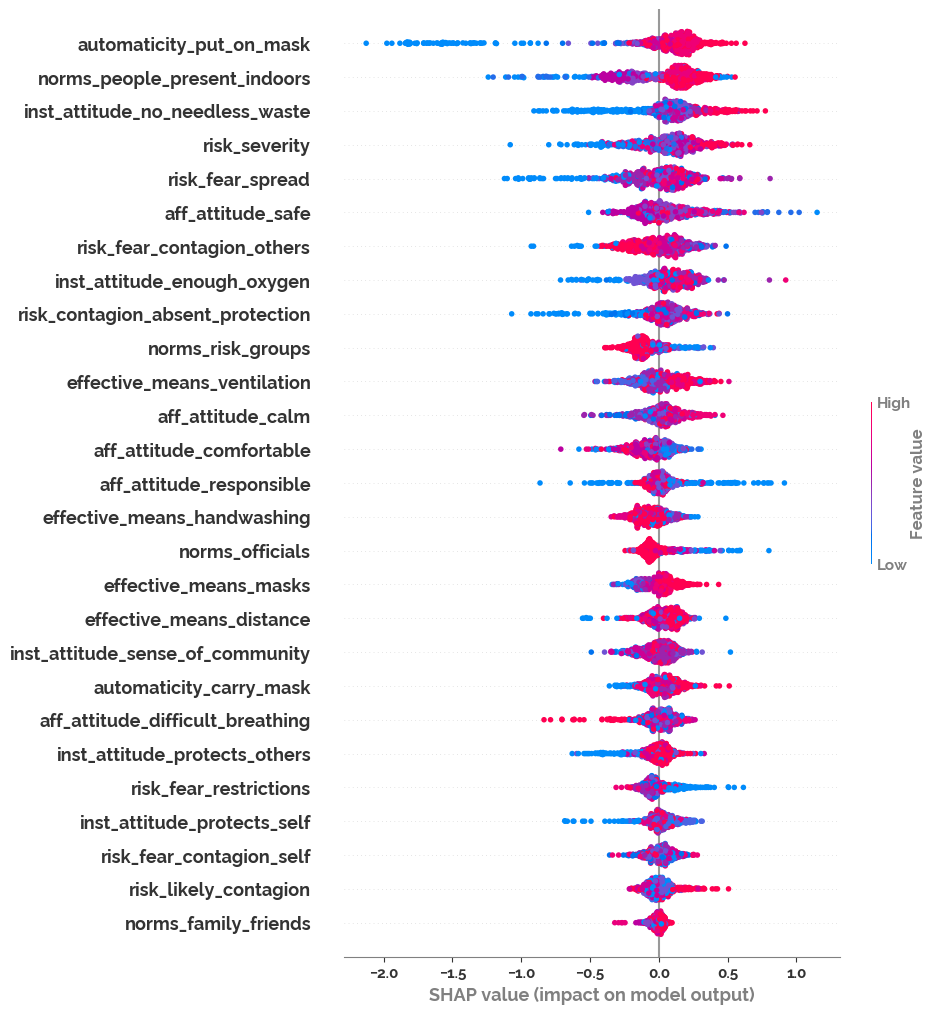

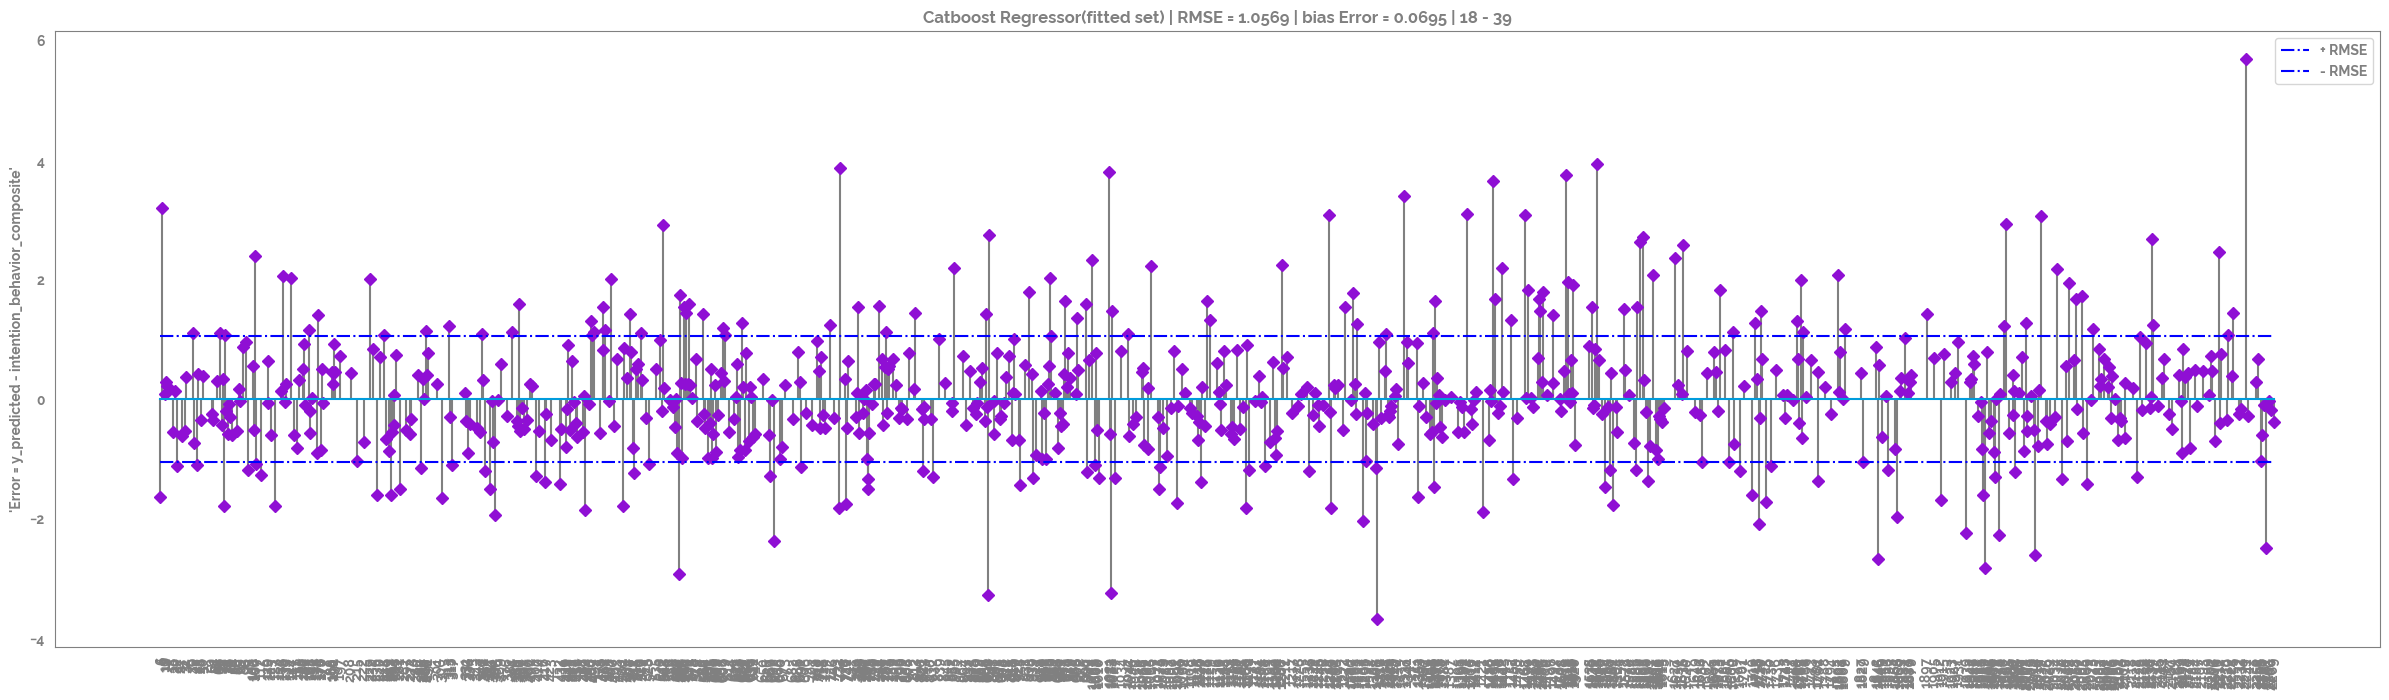

In [29]:
# %%capture
feature_plot_0, gini_plot_0, shap_plot_0, rmse_plot_0, feature_importance_df_0, shap_values_0 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['18-29', '30-39'])],
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list,
                                                                                                                                   plot_title="18 - 39"
                                                                                  )

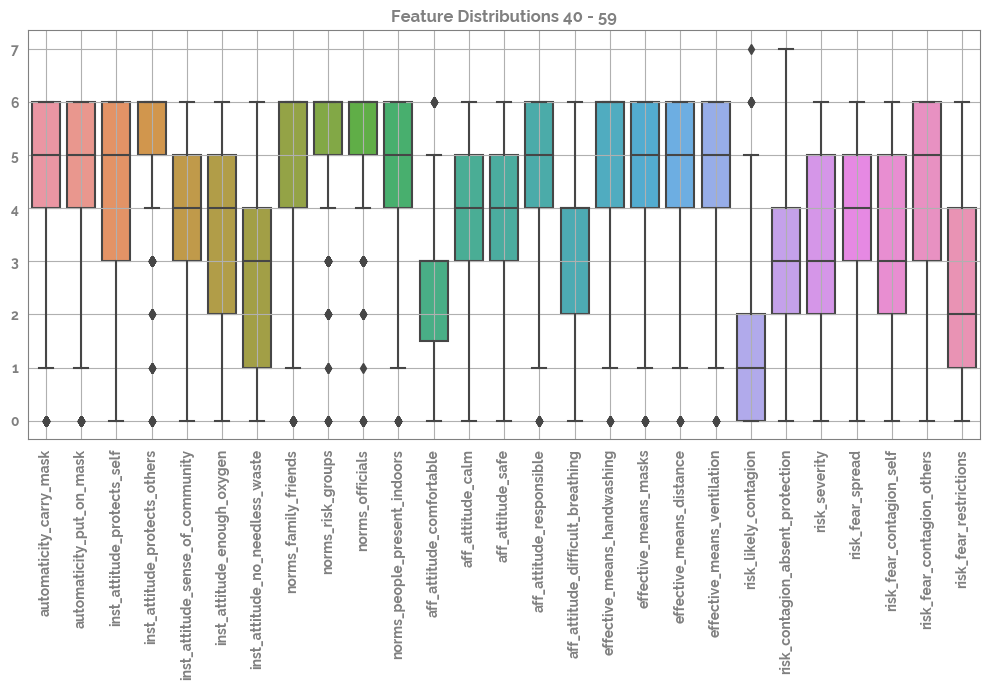

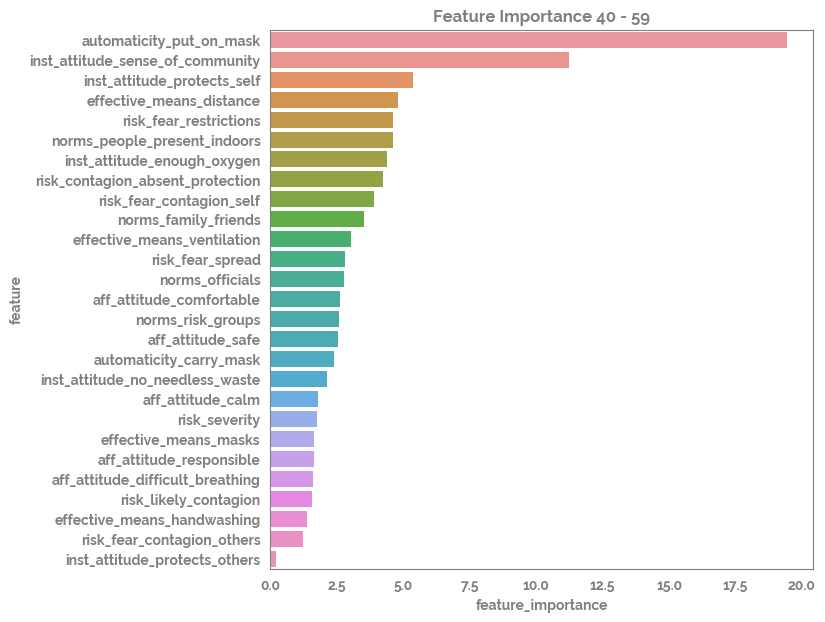

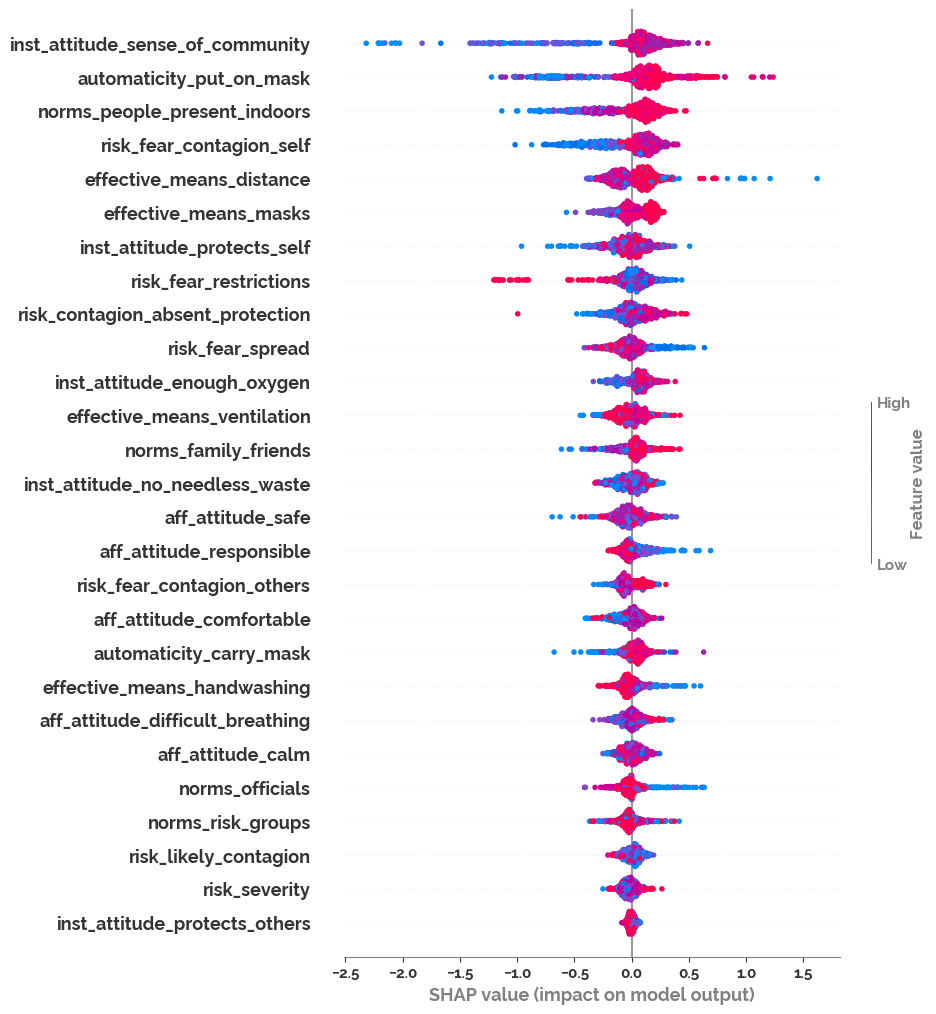

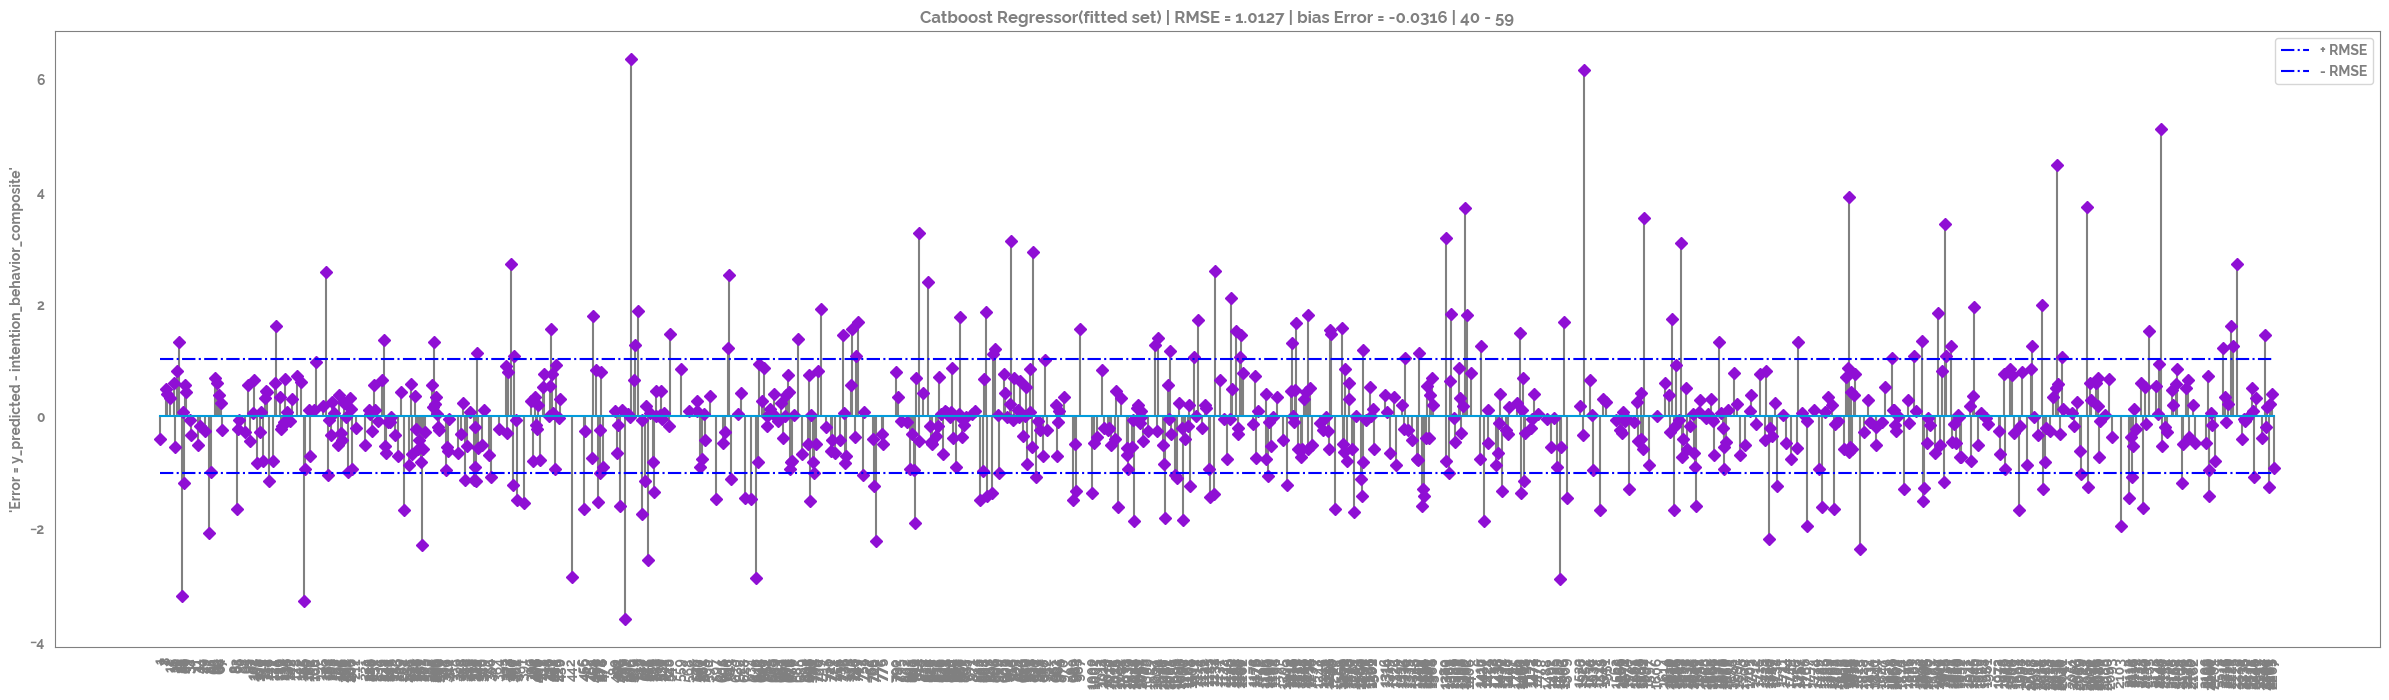

In [30]:
feature_plot_1, gini_plot_1, shap_plot_1, rmse_plot_1, feature_importance_df_1, shap_values_1 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['40-49', '50-59'])],
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list,
                                                                                                                                   plot_title="40 - 59"
                                                                                  )

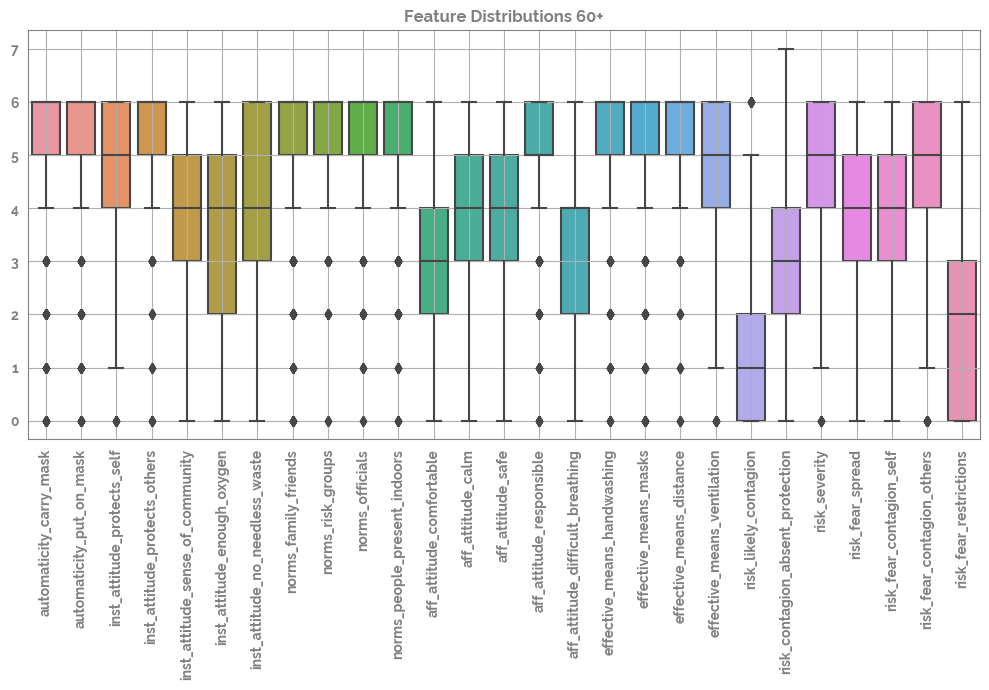

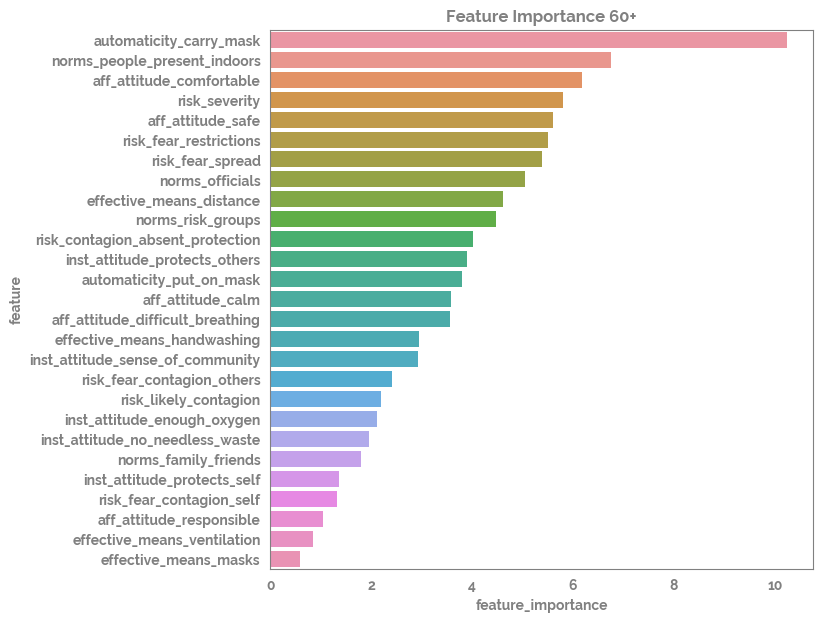

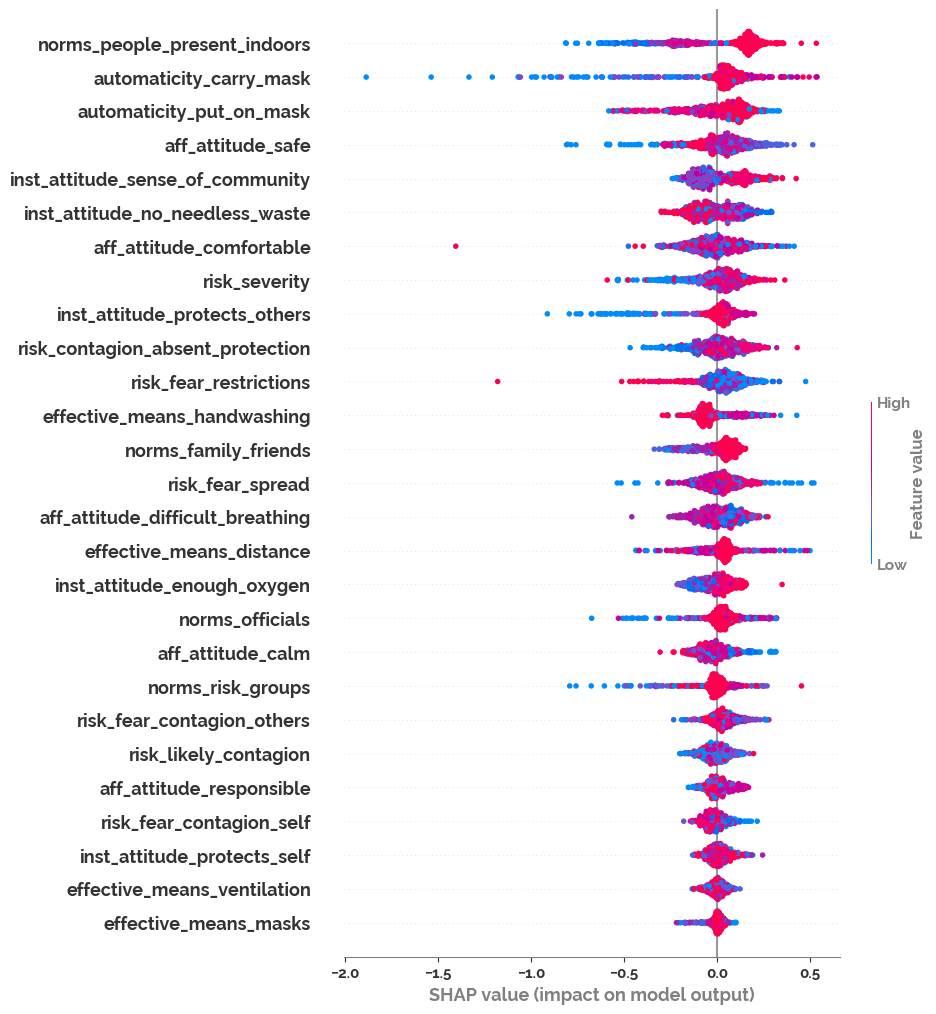

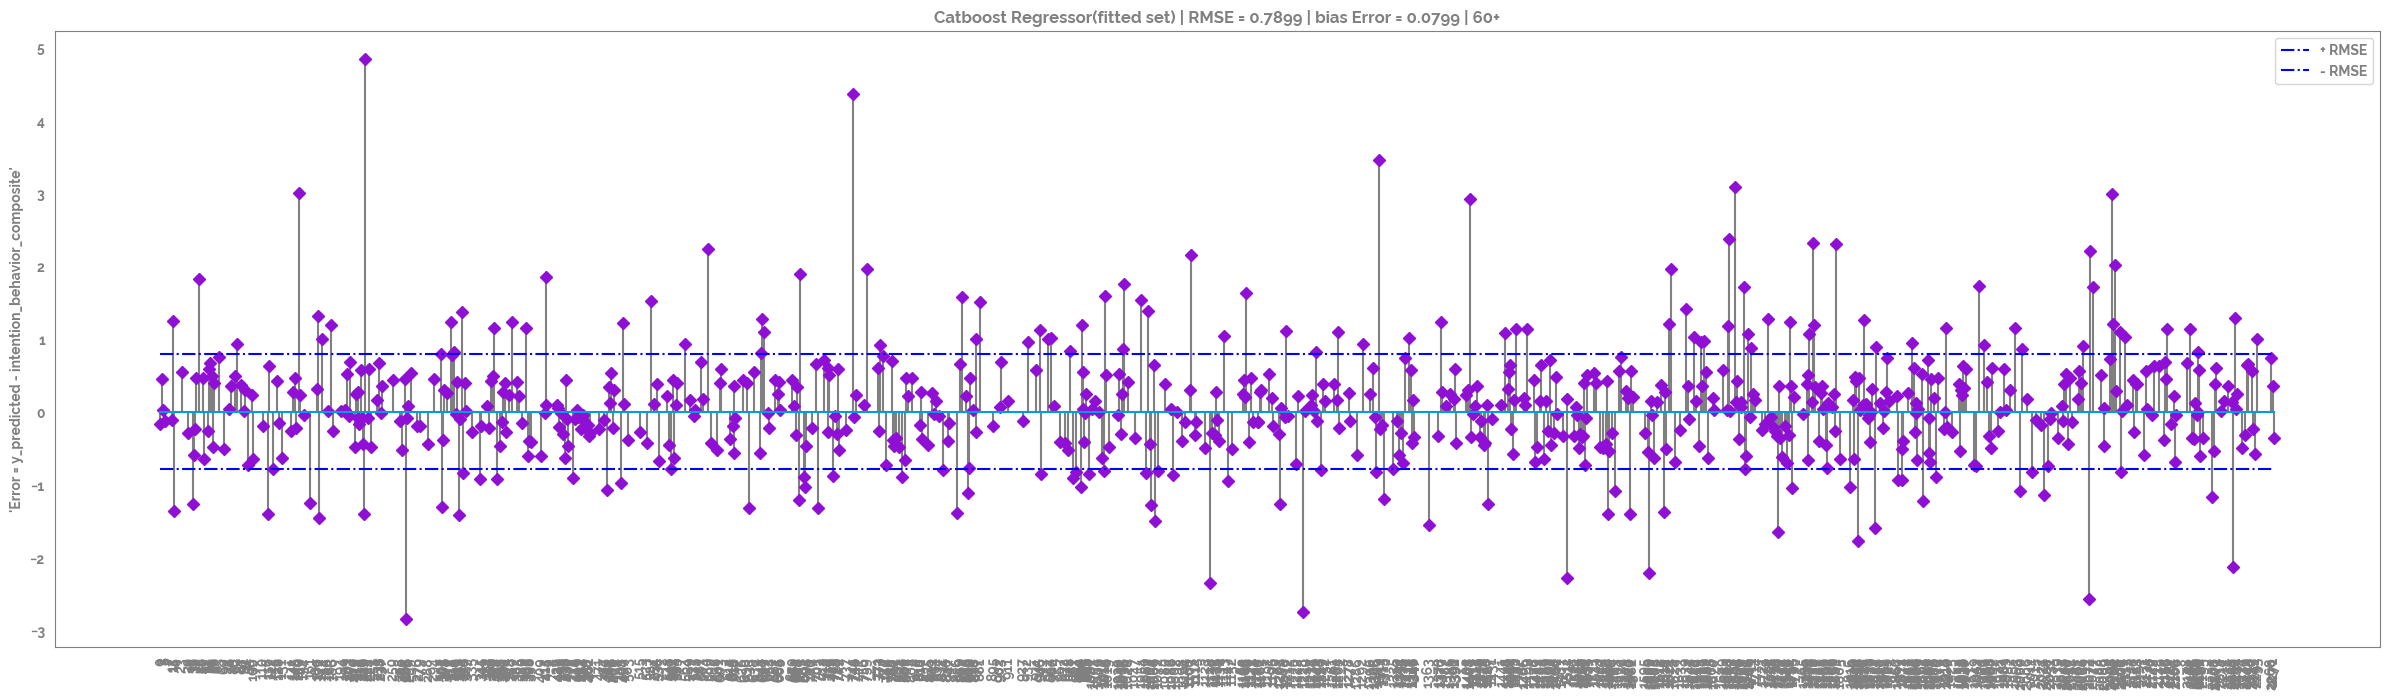

In [31]:
feature_plot_2, gini_plot_2, shap_plot_2, rmse_plot_2, feature_importance_df_2, shap_values_2 = naive_catboost_forest_summary(df = df[df["demographic_age"].isin(['60+'])],
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list,
                                                                                                                                   plot_title="60+"
                                                                                  )

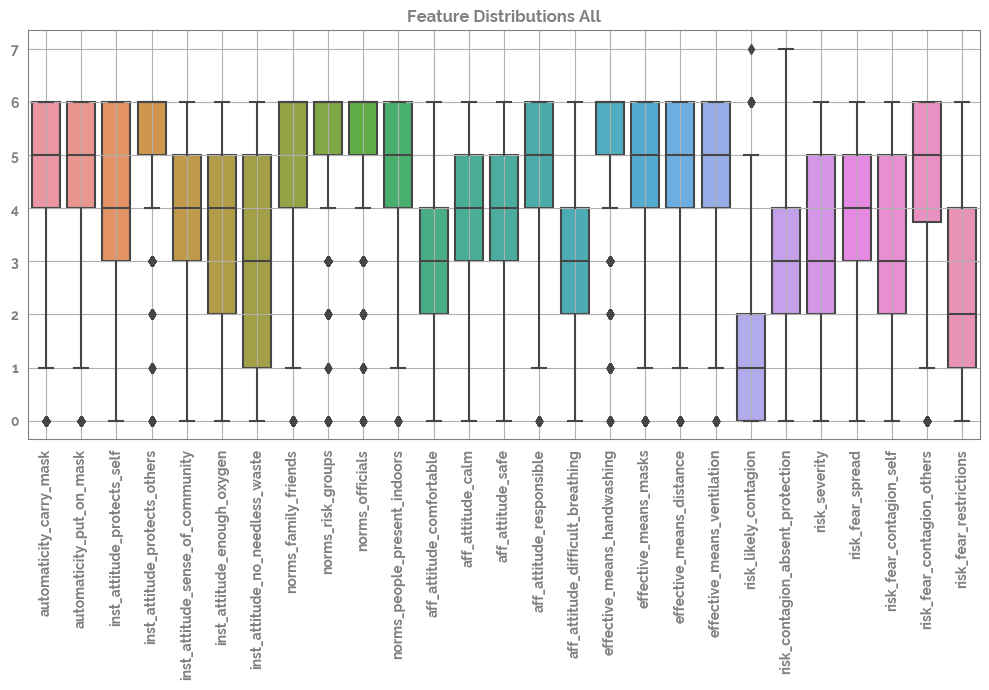

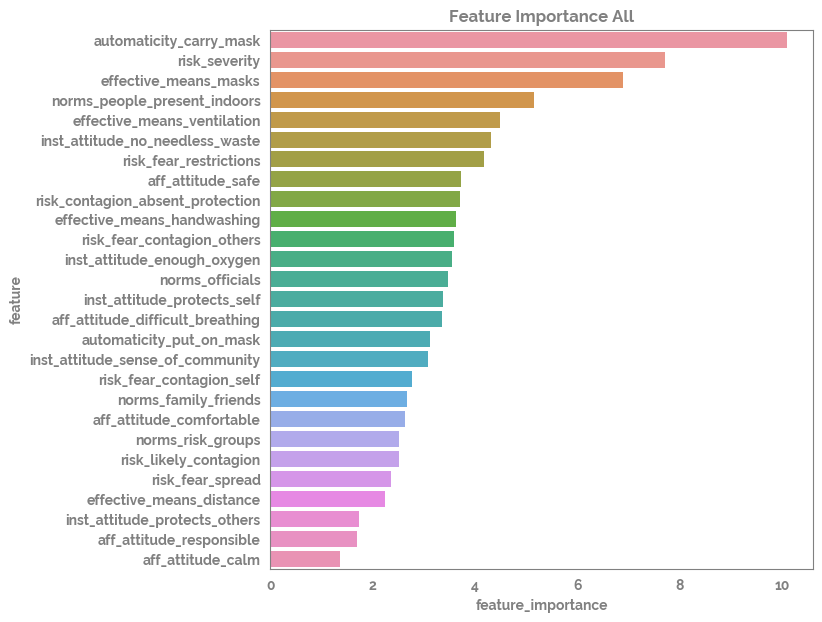

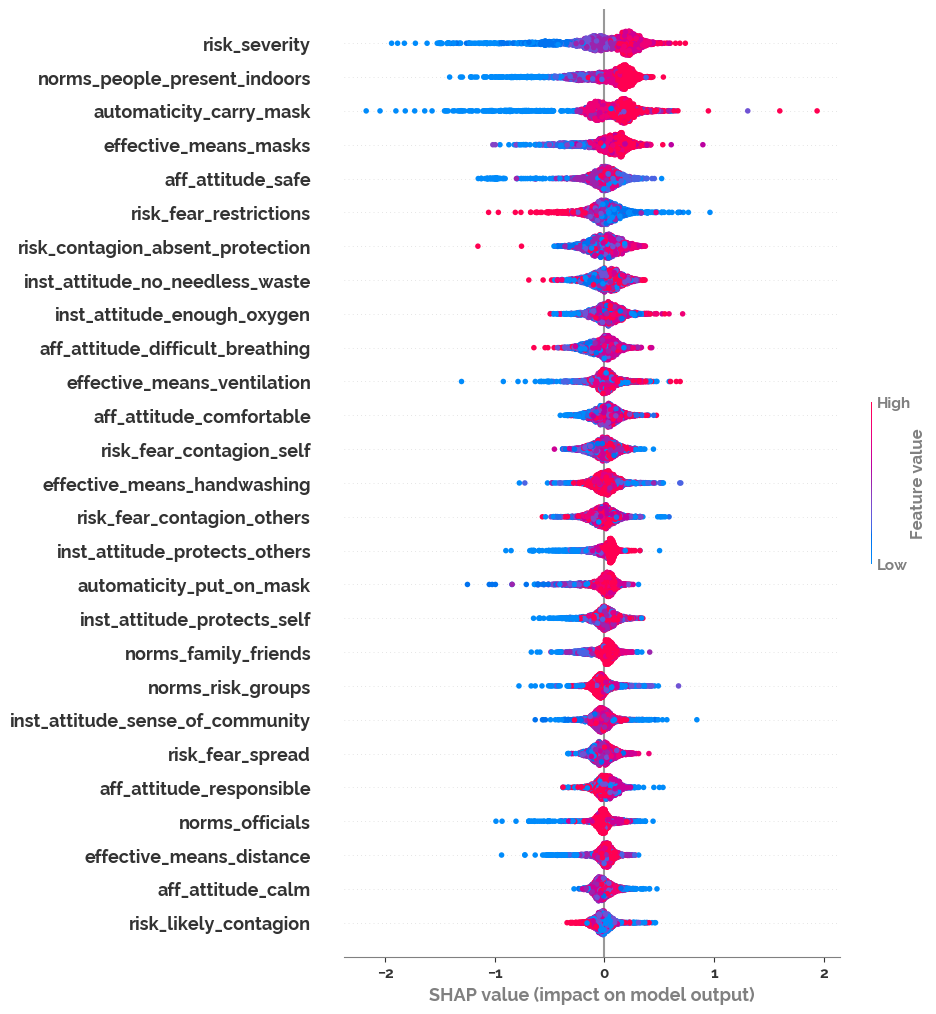

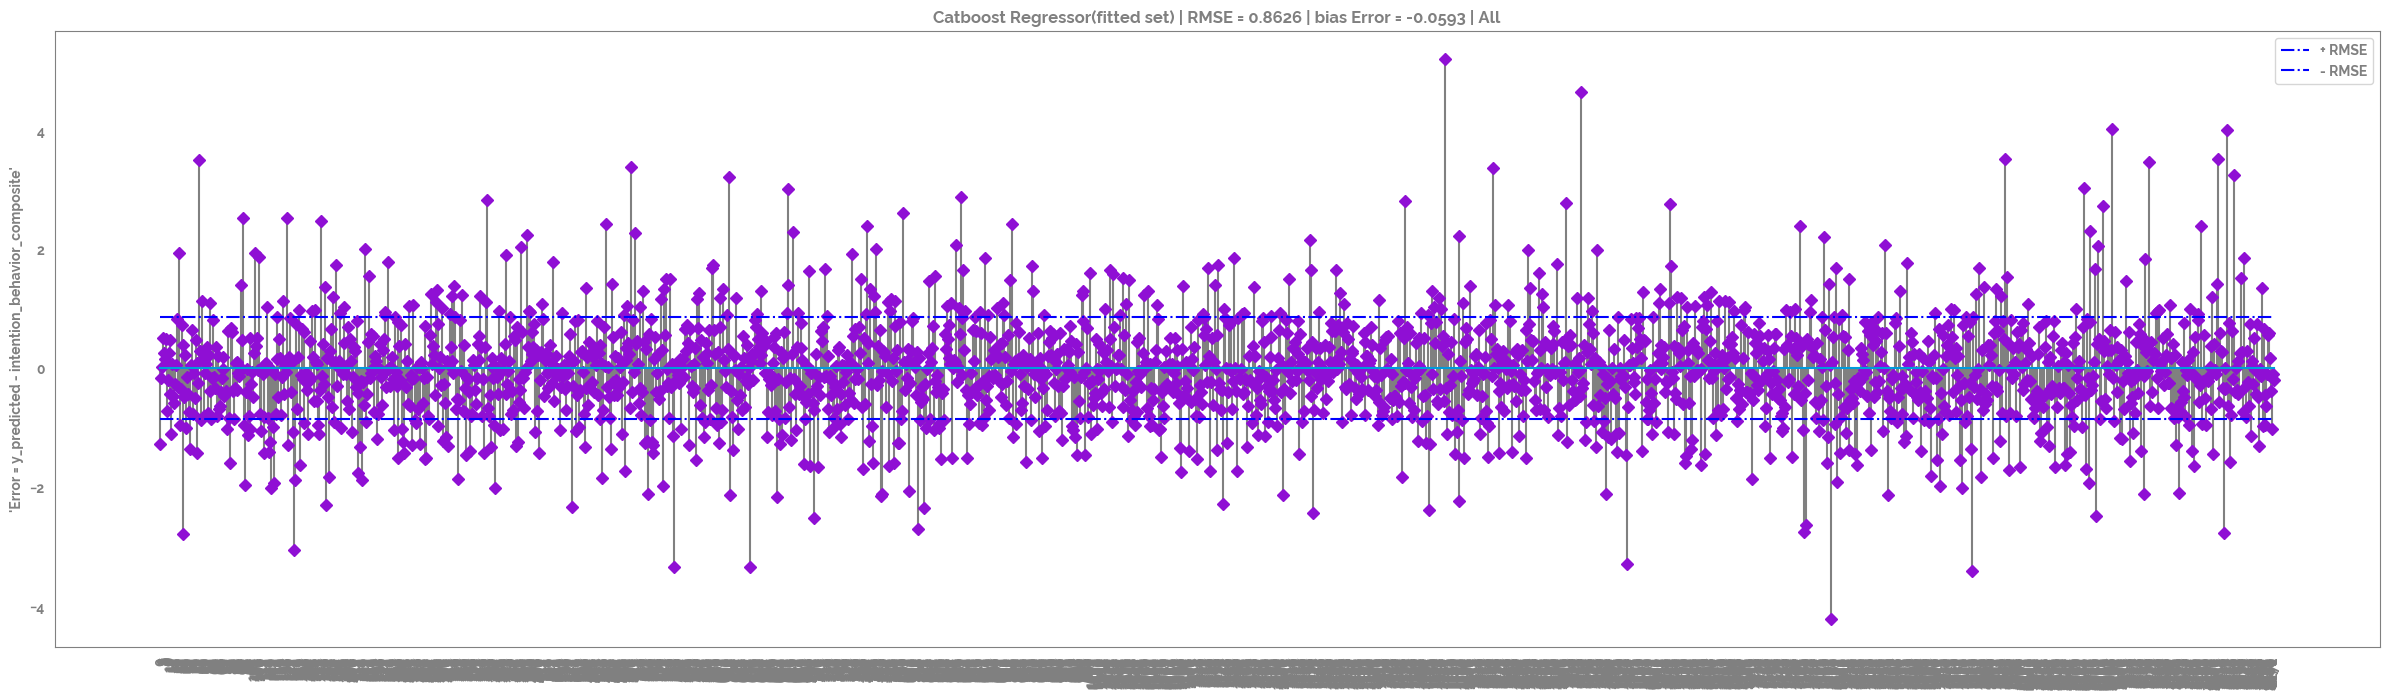

In [32]:
feature_plot_3, gini_plot_3, shap_plot_3, rmse_plot_3, feature_importance_df_3, shap_values_3 = naive_catboost_forest_summary(df = df,
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list,
                                                                                                                                   plot_title="All"
                                                                                  )

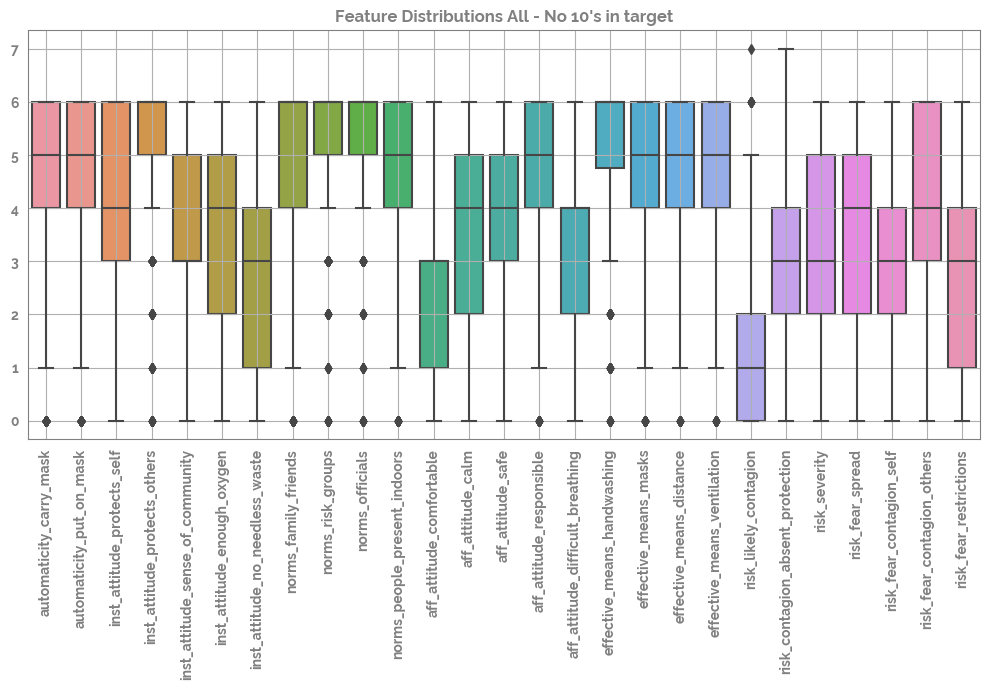

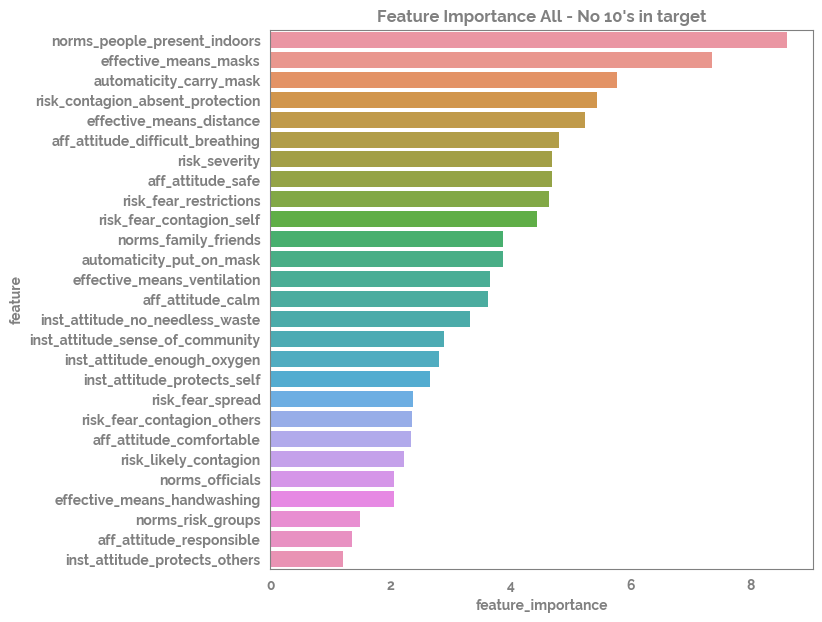

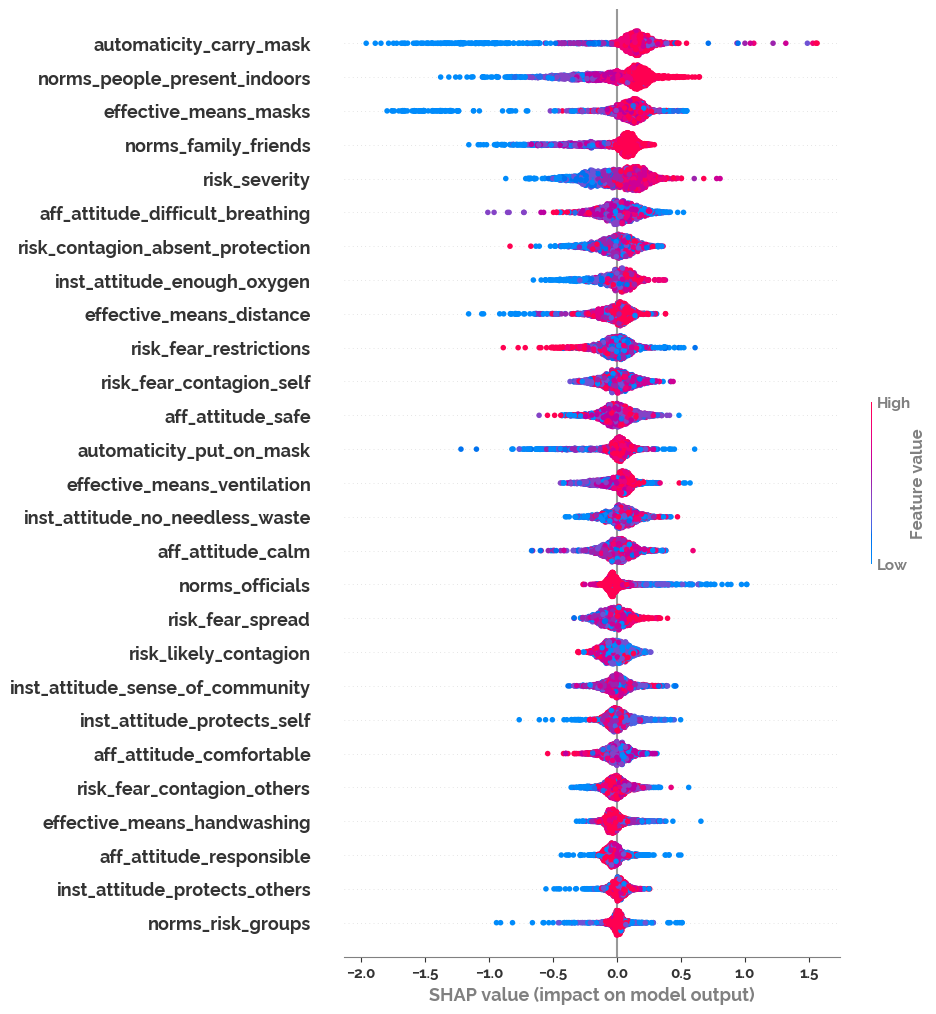

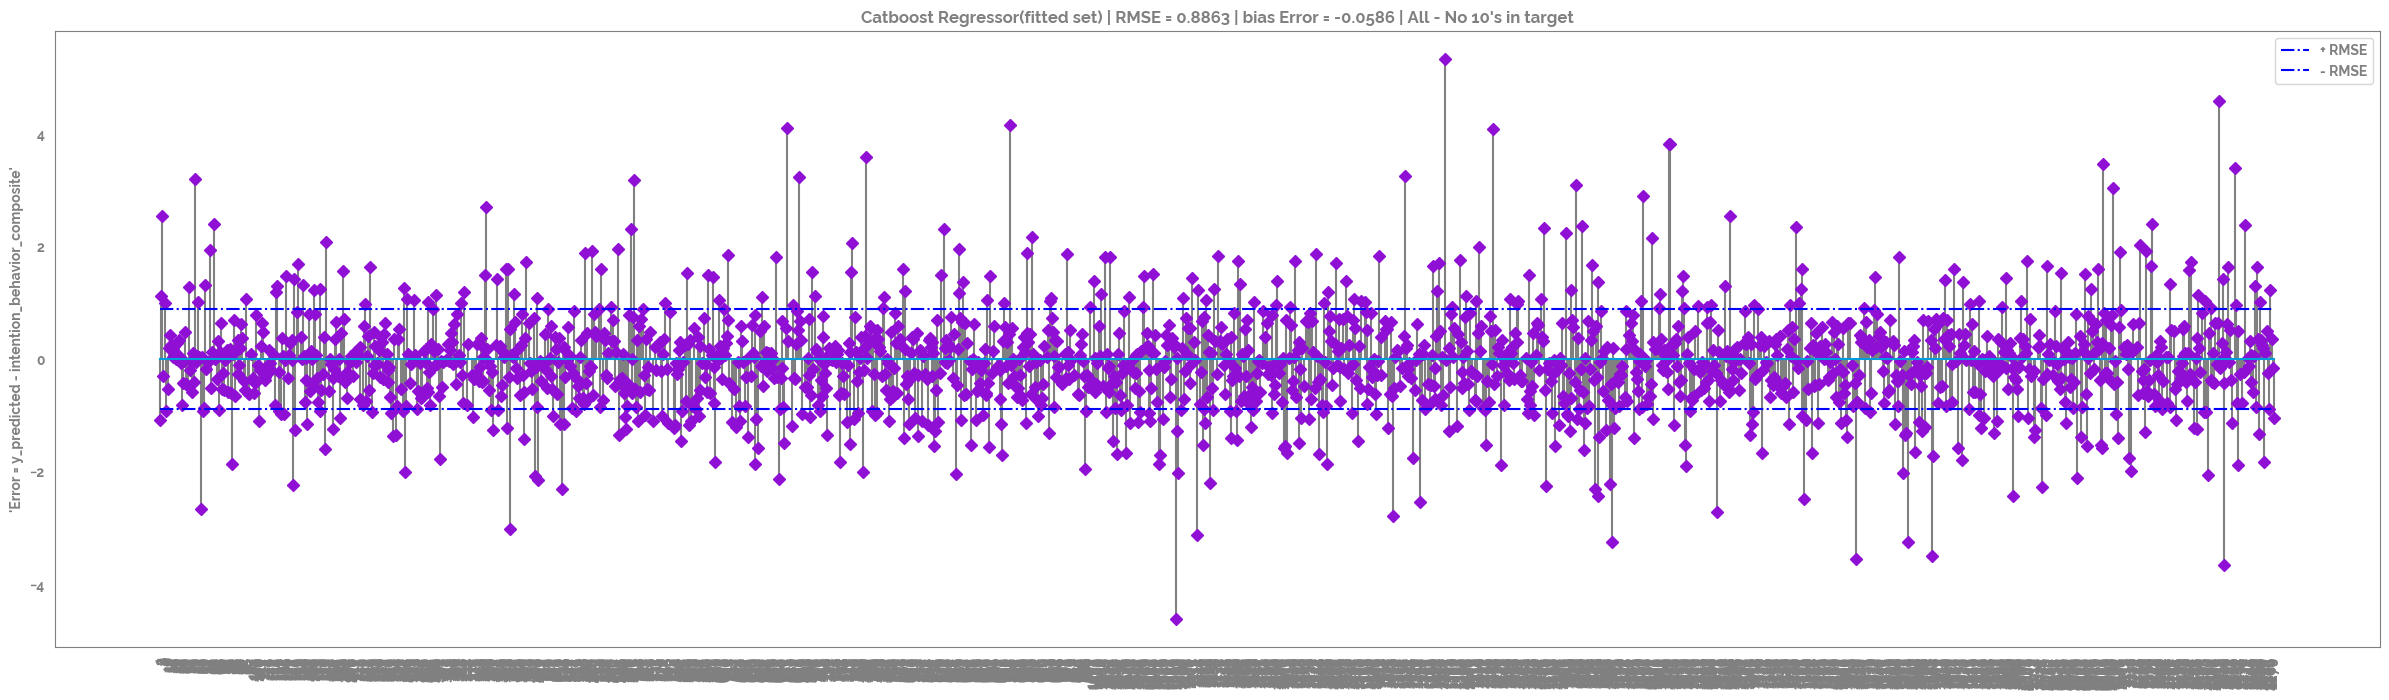

In [33]:
feature_plot_4, gini_plot_4, shap_plot_4, rmse_plot_4, feature_importance_df_4, shap_values_4 = naive_catboost_forest_summary(df = df[df[grouping_var]!=10],
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list,
                                                                                                                                   plot_title="All - No 10's in target"
                                                                                  )

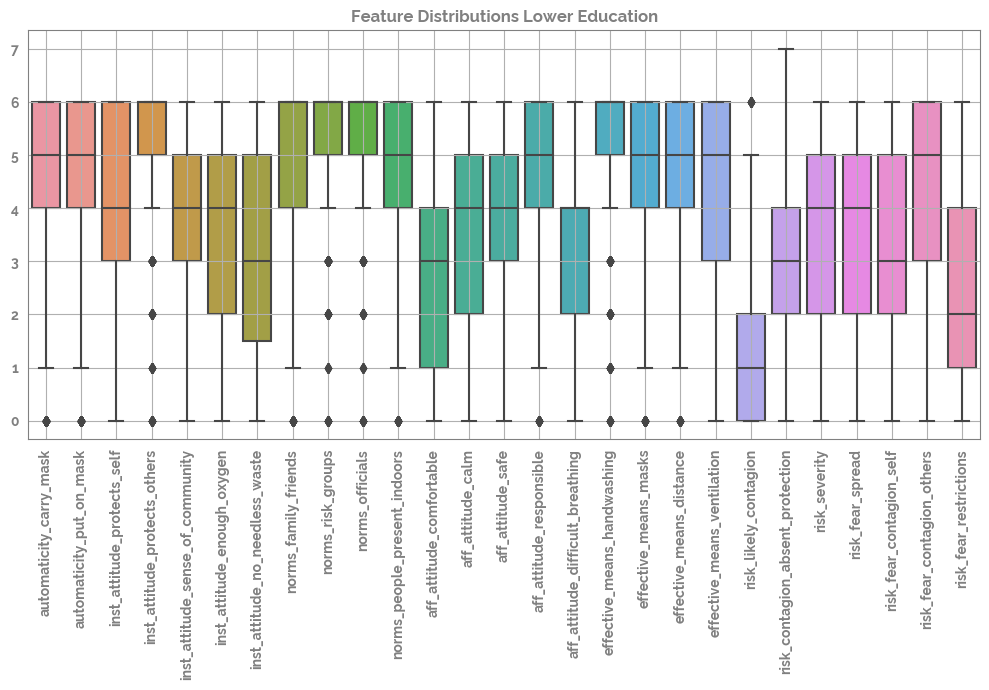

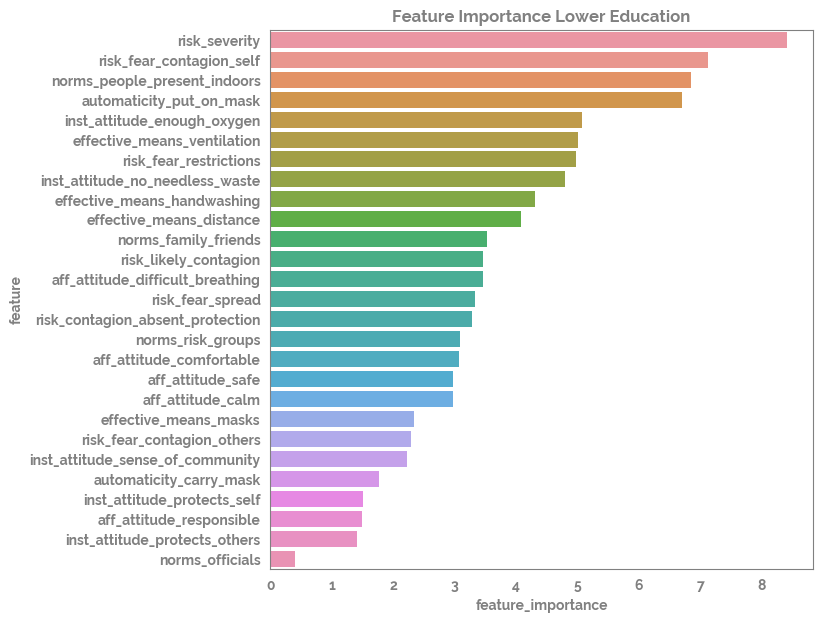

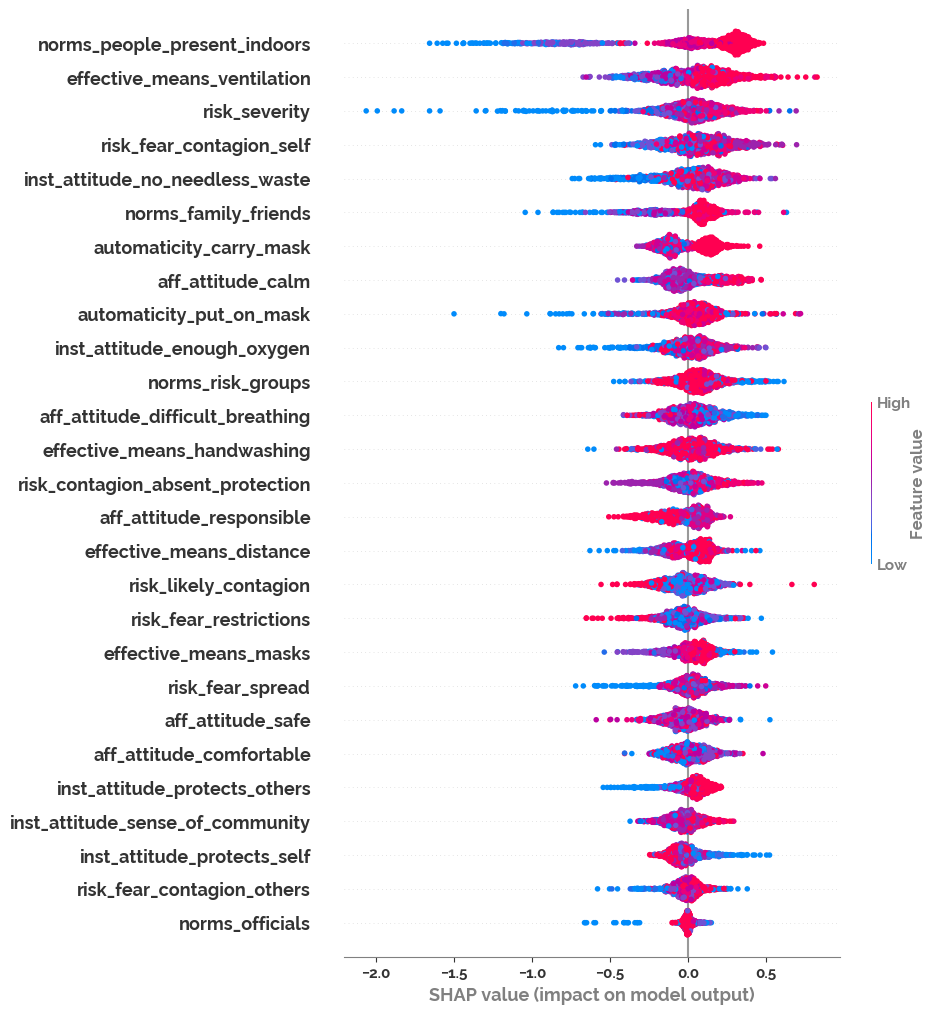

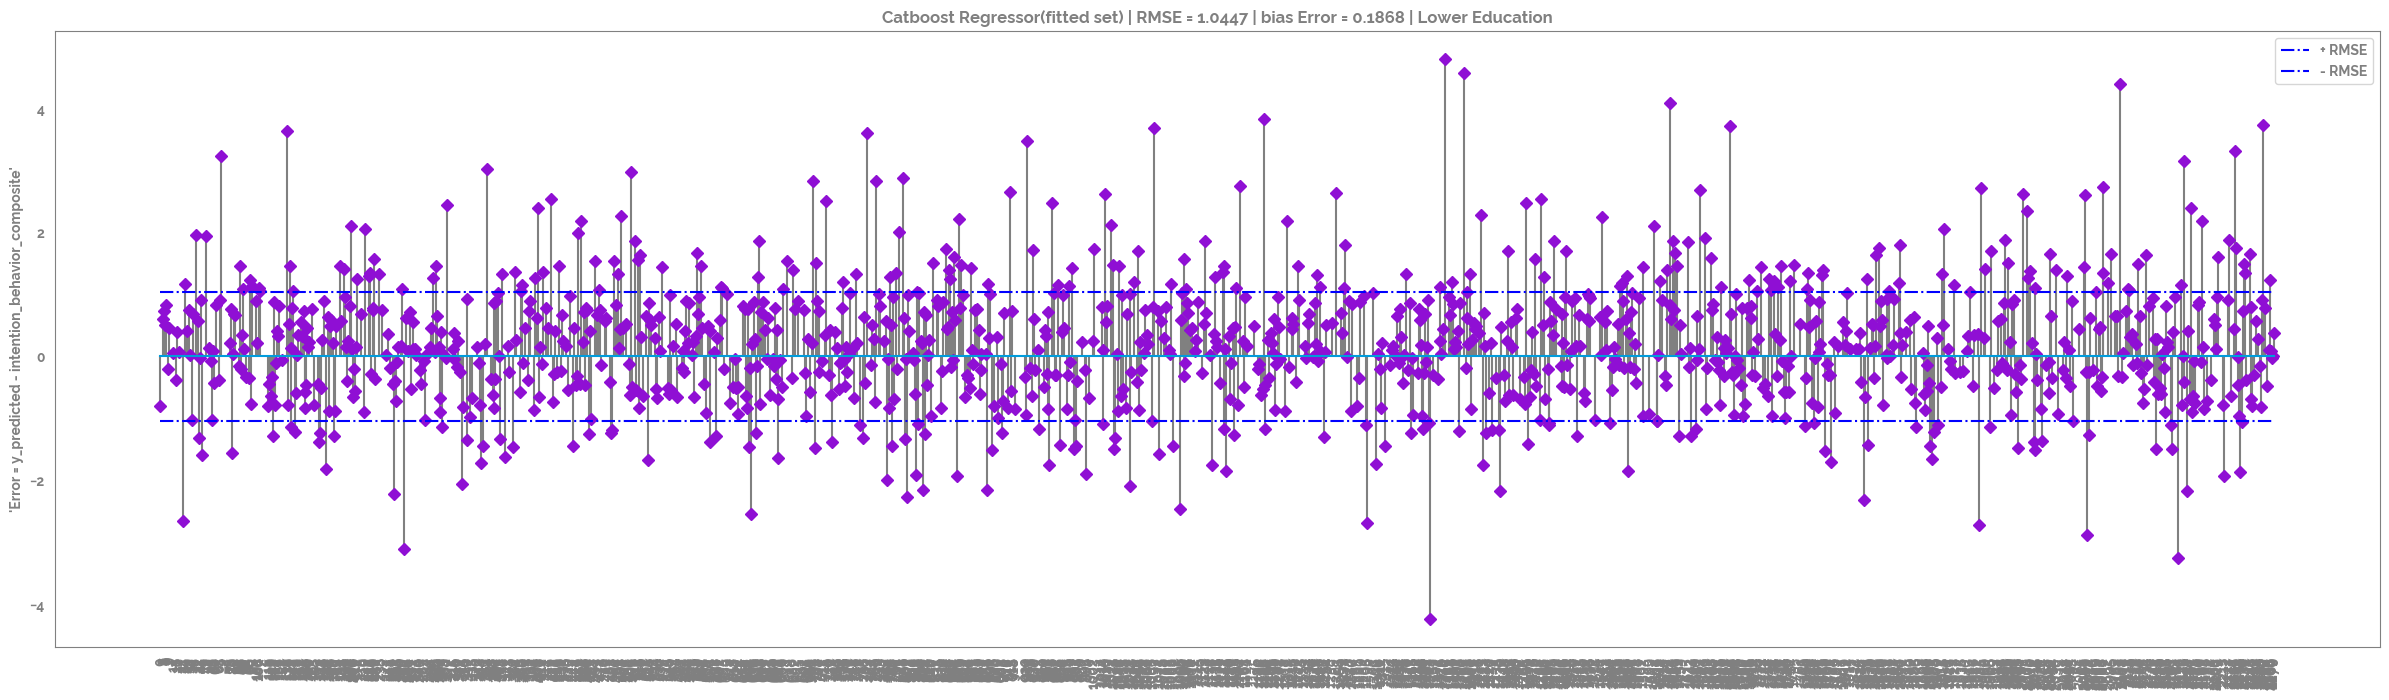

In [34]:
feature_plot_5, gini_plot_5, shap_plot_5, rmse_plot_5, feature_importance_df_5, shap_values_5 = naive_catboost_forest_summary(df = df[df["demographic_higher_education"]==0],
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list,
                                                                                                                                   plot_title="Lower Education"
                                                                                  )

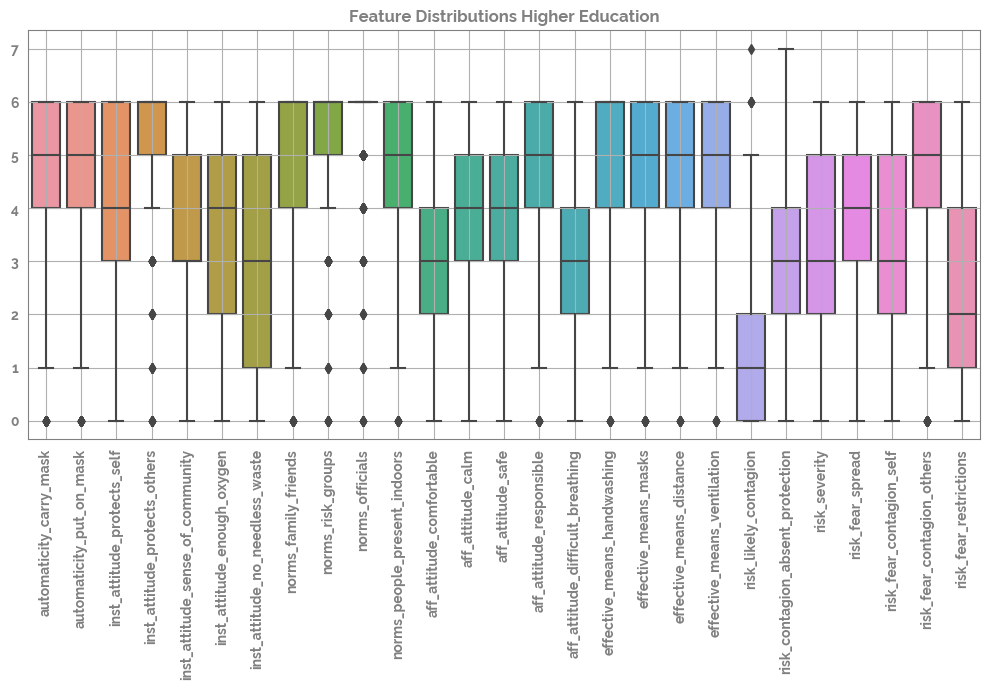

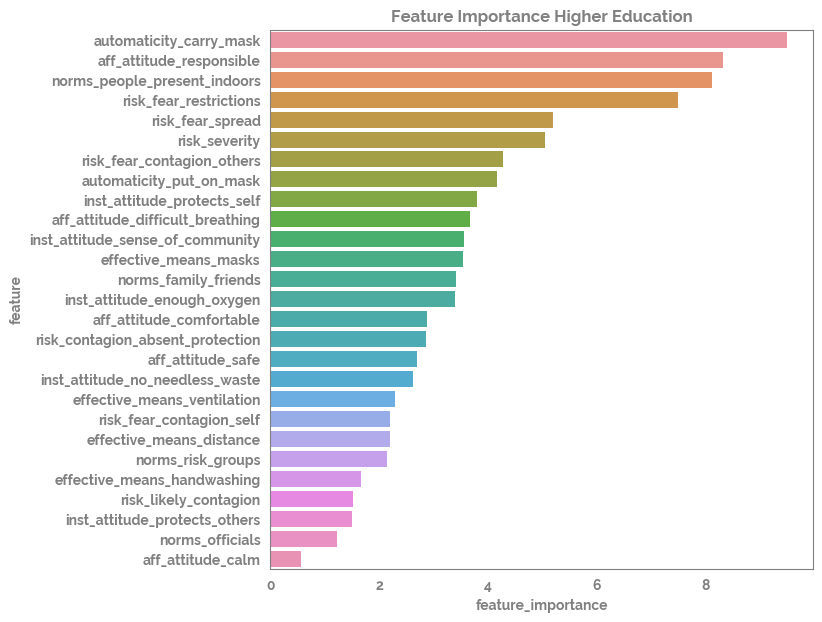

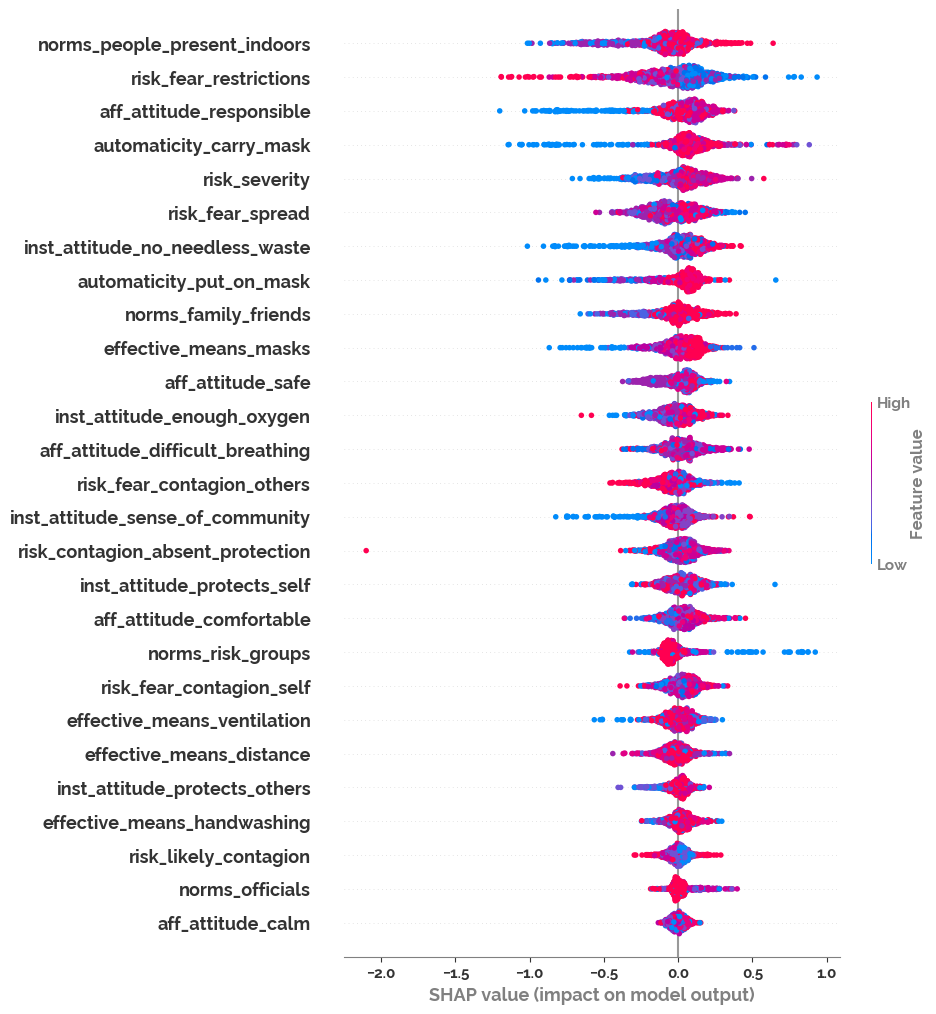

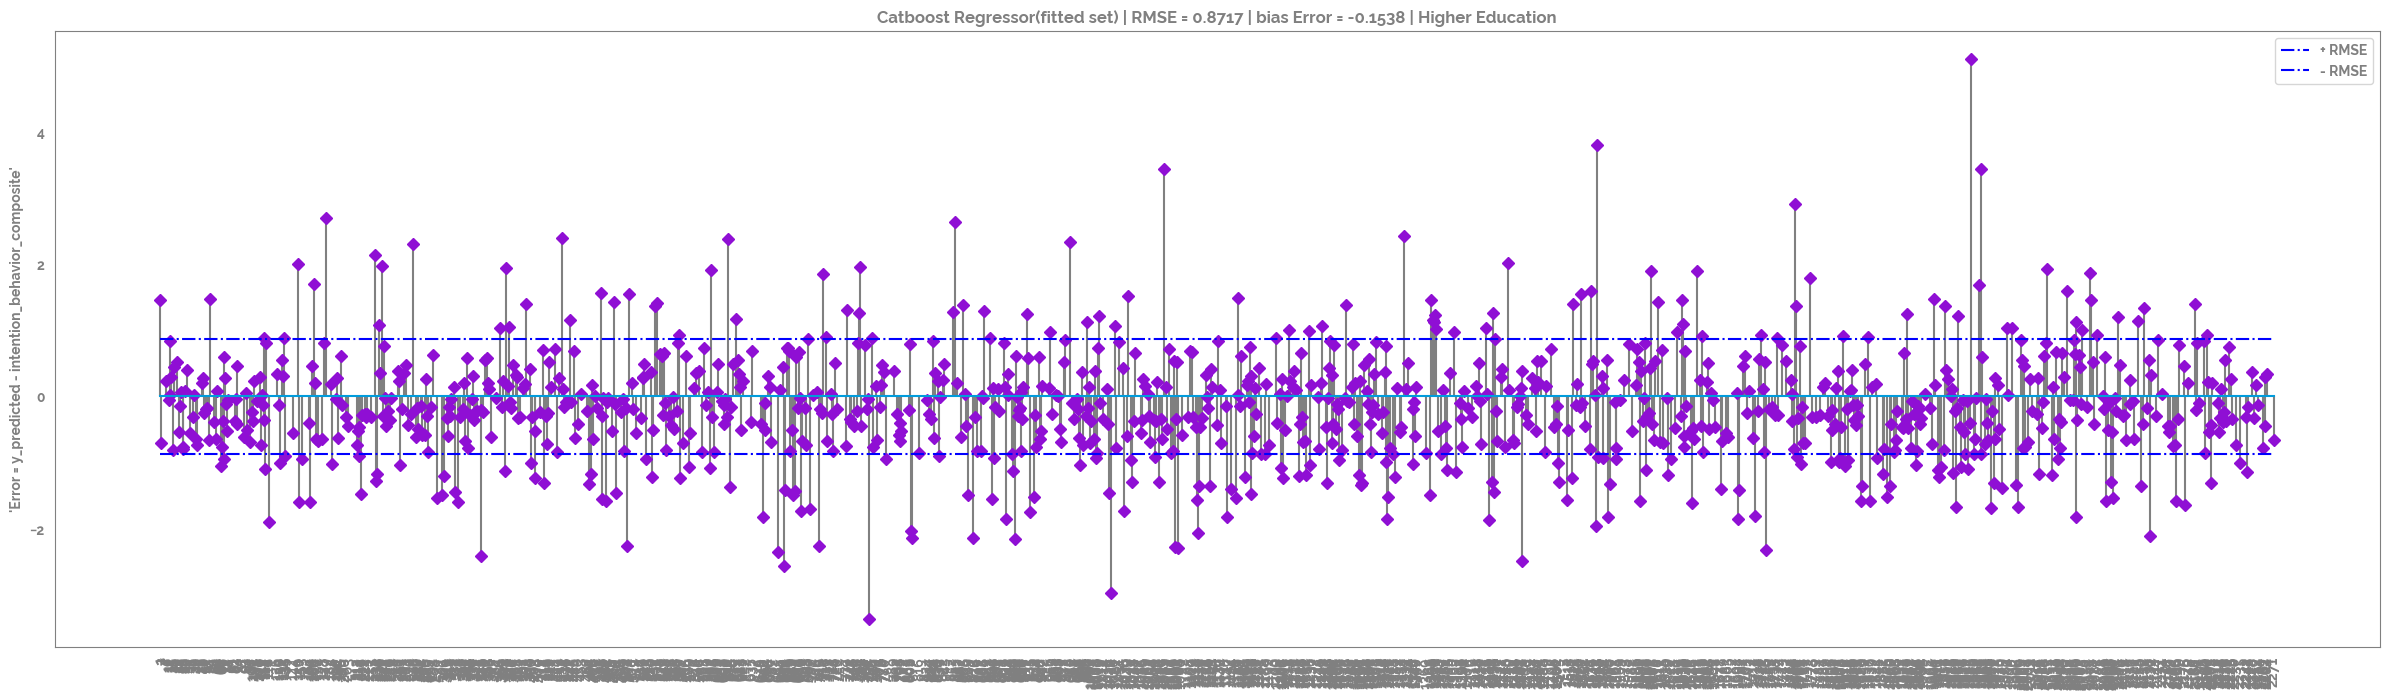

In [35]:
feature_plot_6, gini_plot_6, shap_plot_6, rmse_plot_6, feature_importance_df_6, shap_values_6 = naive_catboost_forest_summary(df = df[df["demographic_higher_education"]==1],
                                                                                   grouping_var = grouping_var,
                                                                                   column_list = features_list,
                                                                                                                                   plot_title="Higher Education"
                                                                                  )

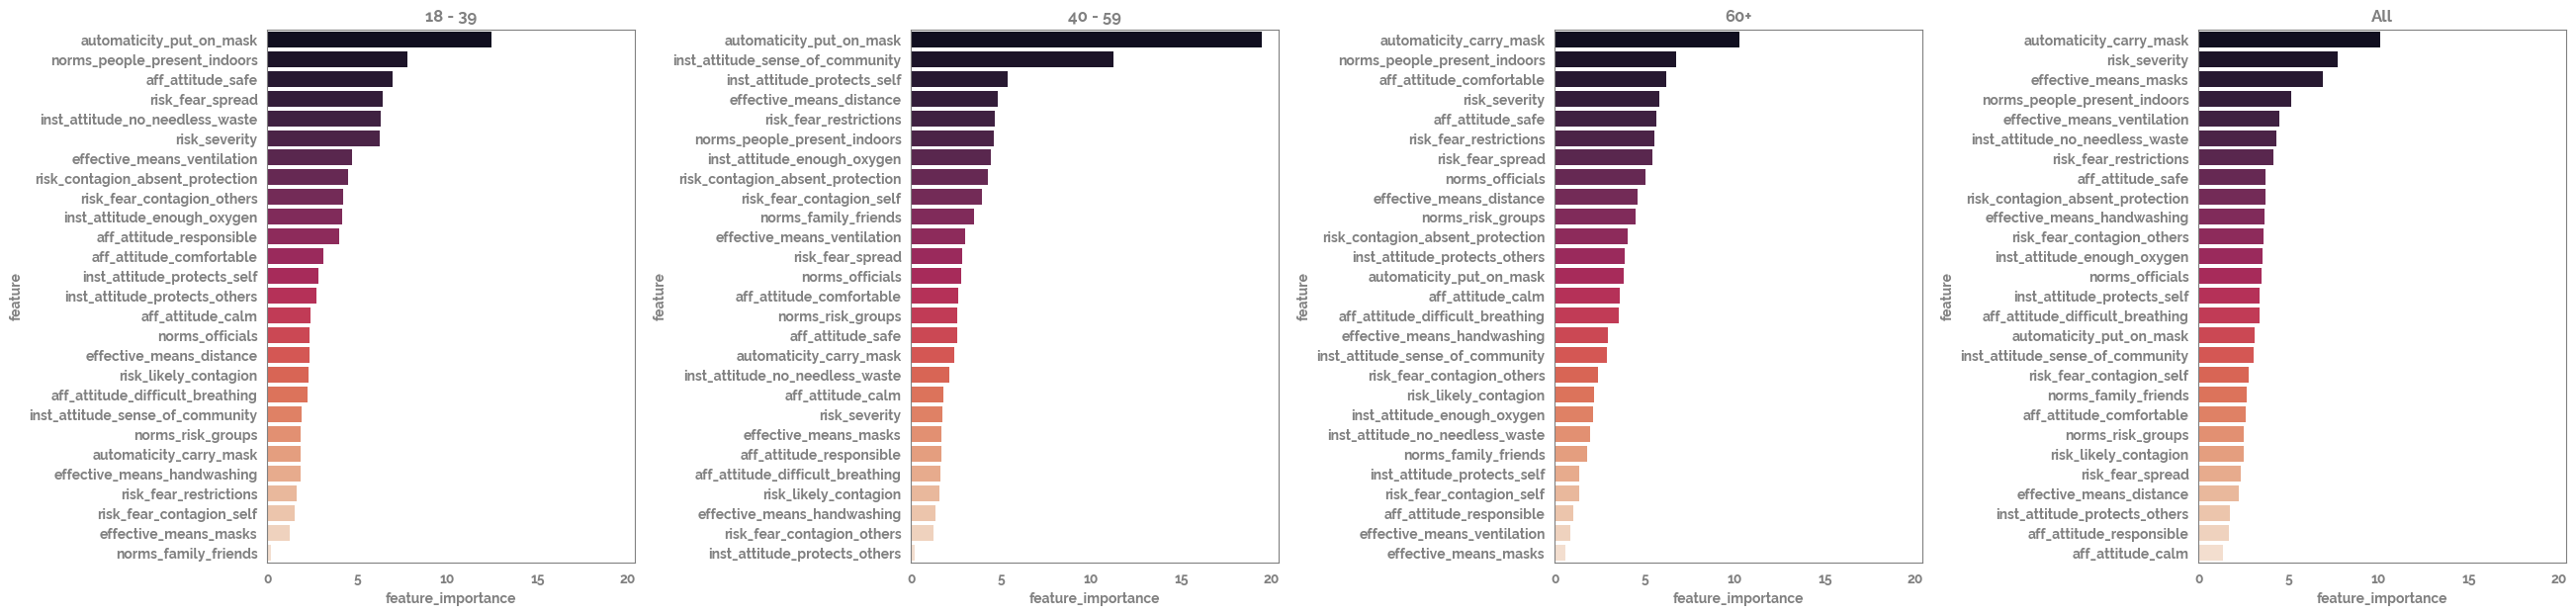

In [36]:
fig, axs = plt.subplots(nrows=1,
                 ncols=4,
                 sharex=True,
                 sharey=False,
                       figsize=(30, 7),
                       gridspec_kw={'wspace': 0.75})
fi_dfs_list = [feature_importance_df_0, feature_importance_df_1, feature_importance_df_2, feature_importance_df_3]
fi_titles_list = ["18 - 39", "40 - 59", "60+", "All"]

for i in range(0, len(fi_dfs_list)):
    fi_df = fi_dfs_list[i]
    _ = sns.barplot(data=fi_df, 
                    x="feature_importance", 
                    y="feature",
                    ax=axs[i],
                    palette="rocket"
                    )
    _ = axs[i].set_title(fi_titles_list[i])
# _ = plt.show()

In [37]:
fi_dfs_list = [feature_importance_df_0, feature_importance_df_1, feature_importance_df_2, feature_importance_df_3]
fi_titles_list = ["18 - 39", "40 - 59", "60+", "All"]
for i in range(0, len(fi_dfs_list)):
    fi_dfs_list[i]["age_group"] = fi_titles_list[i]

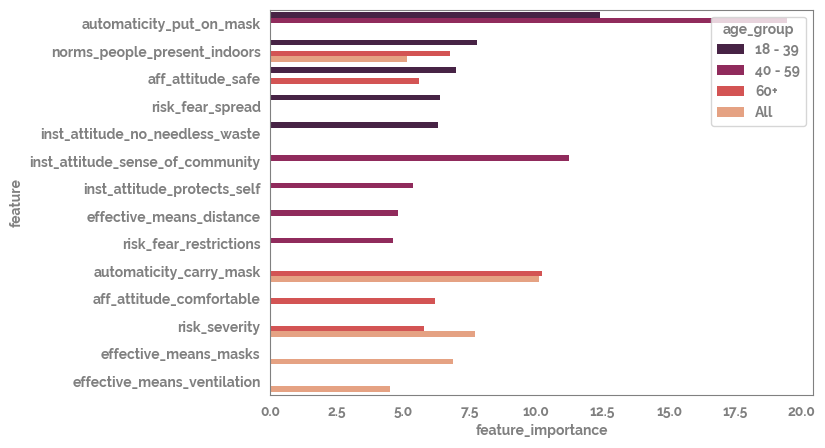

In [38]:
_ = plt.figure(figsize=(7, 5))
_ = sns.barplot(
                data=pd.concat(fi_dfs_list, axis=0).groupby("age_group").head(5),
                x="feature_importance", 
                y="feature",
                hue="age_group",
                palette="rocket",
                dodge=True
                )

In [39]:
fis_df = pd.concat(fi_dfs_list, axis=1)

In [40]:
fis_df.head(5)

feature  feature_importance age_group  \
0         automaticity_put_on_mask               12.42   18 - 39   
1     norms_people_present_indoors                7.77   18 - 39   
2                aff_attitude_safe                6.97   18 - 39   
3                 risk_fear_spread                6.38   18 - 39   
4  inst_attitude_no_needless_waste                6.32   18 - 39   

                            feature  feature_importance age_group  \
0          automaticity_put_on_mask               19.44   40 - 59   
1  inst_attitude_sense_of_community               11.25   40 - 59   
2       inst_attitude_protects_self                5.38   40 - 59   
3          effective_means_distance                4.80   40 - 59   
4            risk_fear_restrictions                4.63   40 - 59   

                        feature  feature_importance age_group  \
0       automaticity_carry_mask               10.24       60+   
1  norms_people_present_indoors                6.76       60+   
2      aff_attitude_comfortable                6.18       60+   
3                 risk_severity                5.80       60+   
4             aff_attitude_safe                5.61       60+   

                        feature  feature_importance age_group  
0       automaticity_carry_mask               10.10       All  
1                 risk_severity                7.71       All  
2         effective_means_masks                6.89       All  
3  norms_people_present_indoors                5.15       All  
4   effective_means_ventilation                4.49       All

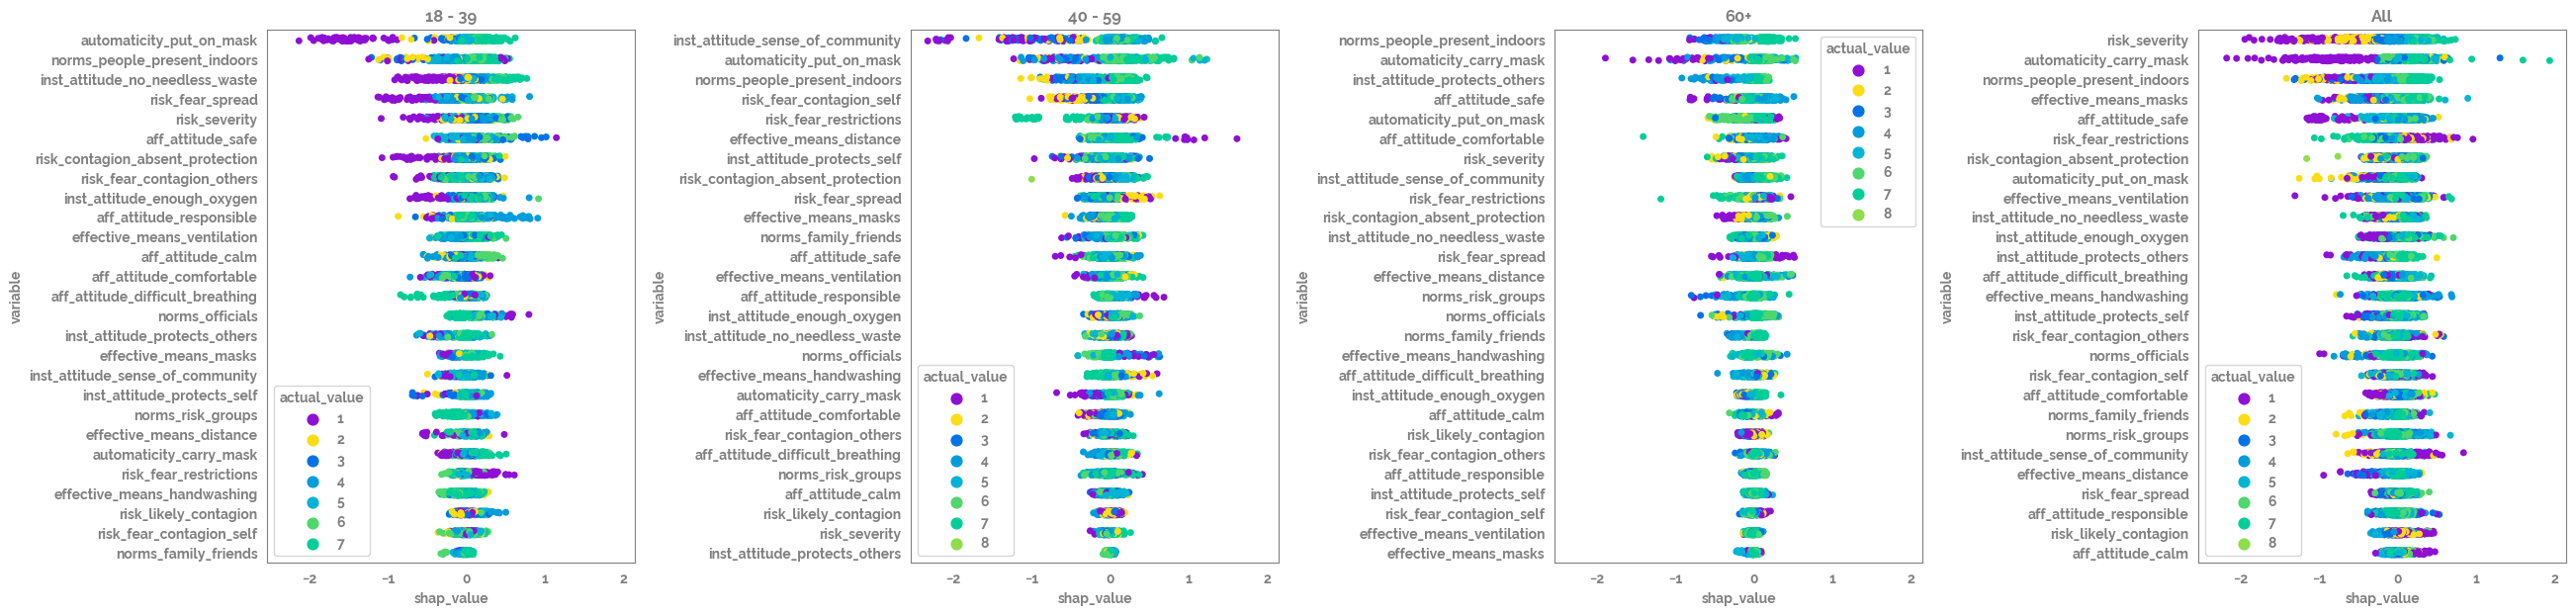

In [41]:
fig, axs = plt.subplots(nrows=1,
                 ncols=4,
                 sharex=True,
                 sharey=False,
                       figsize=(30, 7),
                       gridspec_kw={'wspace': 0.75})
shap_dfs_list = [shap_values_0, shap_values_1, shap_values_2, shap_values_3]
shap_titles_list = ["18 - 39", "40 - 59", "60+", "All"]

for i in range(0, len(shap_dfs_list)):
    shap_df = shap_dfs_list[i]
    var_order = shap_df.groupby("variable").var().sort_values(by = "shap_value", ascending = False).index.tolist()
    _ = sns.stripplot(data=shap_df, 
                    x="shap_value", 
                    y="variable",
                    hue="actual_value",
                  order=var_order,
                    ax=axs[i],
                    )
    _ = axs[i].set_title(shap_titles_list[i])

In [42]:
tmp_df = df.reset_index(drop=True)

X = tmp_df[features_list[2:]]
y = tmp_df[grouping_var]

In [43]:
accuracies_list = list()
all_pred_test_df = pd.DataFrame()
all_cors_df = pd.DataFrame()
kfold = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)
fold_number = 1

model = CatBoostRegressor(iterations=500,
                               depth=None,
                               learning_rate=1,
                               loss_function='RMSE',
                               verbose=False)

# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(X):
    # select rows
    train_X, test_X = X.loc[train_ix, :], X.loc[test_ix, :]
    train_y, test_y = y.loc[train_ix], y.loc[test_ix]
    # summarize train and test composition
    train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
    
    _ = model.fit(X = train_X, 
                y = train_y,
               cat_features=X.columns.tolist())
    
    pred_y = model.predict(test_X)
    _ = accuracies_list.append(np.sqrt(mean_squared_error(test_y, pred_y)))
    
    pred_test_df = pd.DataFrame({grouping_var: test_y,
                 "predict": pred_y,
                                "fold_number": f"fold_{fold_number}"})
    
    all_pred_test_df = pd.concat([all_pred_test_df, 
                             pred_test_df
                            ])

    corr_df = pg.corr(x=pred_test_df[grouping_var], 
            y=pred_test_df["predict"], 
            alternative='two-sided', 
            method='spearman', 
           )
    
    all_cors_df = pd.concat([all_cors_df, 
                             corr_df.assign(fold_number=f"fold_{fold_number}")
                            ])
    
    fold_number += 1

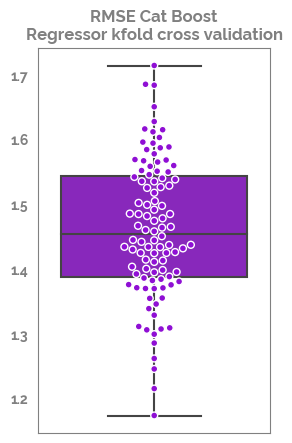

In [44]:
_ = plt.figure(figsize=(3,5))
_ = sns.boxplot(y = accuracies_list)
_ = sns.swarmplot(y = accuracies_list, edgecolor="white", linewidth=1)
_ = plt.title("RMSE Cat Boost\nRegressor kfold cross validation")

In [45]:
pd.DataFrame(accuracies_list).describe().T

count      mean       std       min       25%      50%       75%       max
0  100.0  1.460889  0.107116  1.172973  1.387053  1.45378  1.542548  1.713833

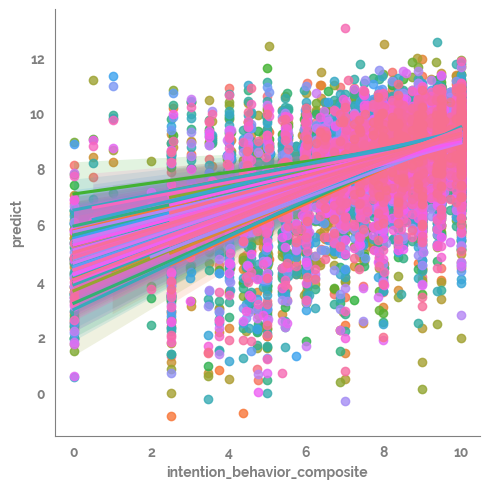

In [46]:
_ = sns.lmplot(data=all_pred_test_df, 
               x=grouping_var, 
               y="predict", 
               hue="fold_number",
              legend=False)

In [51]:
# ax = sns.jointplot(data=all_pred_test_df, 
#                   x=grouping_var, 
#                   y="predict", 
#                   hue="fold_number",
# #                   kind="reg",
#                    legend=False
#                  )
# # _ = ax._legend.remove()

In [60]:
all_cors_df.groupby("fold_number").mean().sort_values(by="r", ascending=False).round(3)

n      r  p-val  power
fold_number                            
fold_58      227.0  0.495  0.000  1.000
fold_12      228.0  0.485  0.000  1.000
fold_98      227.0  0.458  0.000  1.000
fold_10      227.0  0.458  0.000  1.000
fold_79      227.0  0.445  0.000  1.000
...            ...    ...    ...    ...
fold_19      227.0  0.223  0.001  0.924
fold_65      227.0  0.217  0.001  0.911
fold_61      228.0  0.206  0.002  0.881
fold_35      227.0  0.200  0.003  0.859
fold_100     227.0  0.177  0.007  0.766

[100 rows x 4 columns]

In [52]:
all_cors_df.describe()

n           r         p-val       power
count  100.000000  100.000000  1.000000e+02  100.000000
mean   227.200000    0.337624  1.474281e-04    0.989853
std      0.402015    0.063481  8.058543e-04    0.031872
min    227.000000    0.177255  1.944096e-15    0.766244
25%    227.000000    0.293919  4.683890e-09    0.995085
50%    227.000000    0.338370  1.743040e-07    0.999554
75%    227.000000    0.376328  6.681203e-06    0.999965
max    228.000000    0.495058  7.426213e-03    1.000000

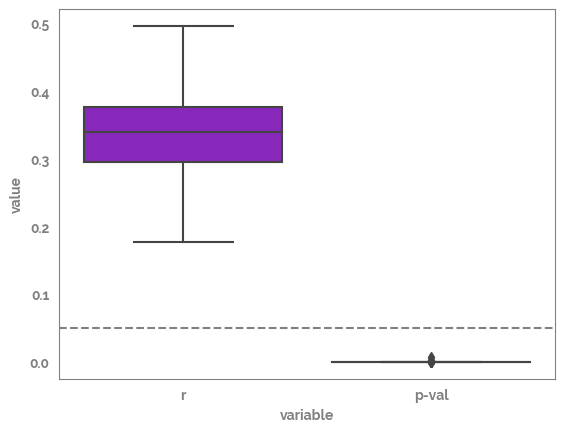

In [53]:
_ = sns.boxplot(data=all_cors_df[["r", "p-val"]].melt(),
                x="variable", y="value")
_ = plt.axhline(y=0.05, c="grey", ls="--")

In [61]:
relabel_column = "Label short" # "Item english translation "

sort_shap_list = (pd.merge(shap_values_3
         .assign(shap_value=lambda d: d[["shap_value"]].abs())
         .groupby("variable")
         .mean()
         .sort_values(by="shap_value", ascending=False), 
         meta_df.loc[meta_df["New variable name"].isin(features_list), [relabel_column, "New variable name"]],
         left_index=True,
         right_on="New variable name")
 .set_index(["New variable name", relabel_column])
 .index
 .tolist()
#  .drop("New variable name", axis=1)
)

In [62]:
sort_shap_long_list = (pd.merge(shap_values_3
         .assign(shap_value=lambda d: d[["shap_value"]].abs())
         .groupby("variable")
         .mean()
         .sort_values(by="shap_value", ascending=False), 
         meta_df.loc[meta_df["New variable name"].isin(features_list), [relabel_column, "New variable name", 'English lo-anchor', 'English hi-anchor']],
         left_index=True,
         right_on="New variable name")
 .set_index(["New variable name", relabel_column, 'English lo-anchor', 'English hi-anchor'])
 .index
 .tolist()
#  .drop("New variable name", axis=1)
)

In [63]:
pd.Series([x[1] for x in sort_shap_list])

0                          Perceived risk severity coronavirus infection
1      In the indoors spaces I visit, people on the site think I should…
2                           Is taking a mask with you automatic for you?
3                                                      Using a face mask
4                       When I use a face mask, I feel or would feel ...
5                                   Measures taken to prevent the spread
6     Perceived risk coronavirus infection with no protective behaviours
7                                          If or when I use a face mask…
8                                          If or when I use a face mask…
9                       When I use a face mask, I feel or would feel ...
10                                                           Ventilation
11                      When I use a face mask, I feel or would feel ...
12                                        I would get infected myself ..
13                                        Hand wash

In [64]:
def naive_catboost_shap(df: pd.DataFrame,
                                 grouping_var: str,
                                 column_list: list,
                                  plot_title: str,
                        max_display: int
                                 ):
    y = df[grouping_var]
    X = df[column_list]

    model = CatBoostRegressor(iterations=500,
                               depth=None,
                               learning_rate=1,
                               loss_function='RMSE',
                               verbose=False)

    # train the model
    _ = model.fit(X, y, cat_features=column_list)

    shap_values = model.get_feature_importance(Pool(X, label=y,cat_features=X.columns.tolist()), type="ShapValues")

    shap_values = shap_values[:,:-1]

    _ = shap.summary_plot(shap_values, 
                                  X.astype(int), 
                                  feature_names=X.columns, 
                                  max_display=max_display,
                                 show=False,
                         title=plot_title) 
    shap_plot = plt.gca()
    return shap_plot.get_figure()

In [65]:
display_length = 10

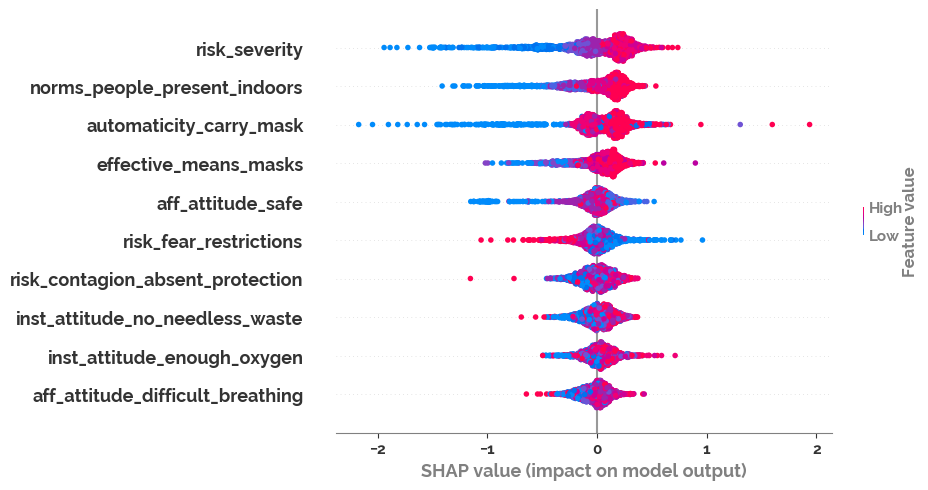

In [66]:
short_shap_plot_all = naive_catboost_shap(df = df,
                    grouping_var = grouping_var,
                    column_list = features_list,
                    plot_title="All",
                   max_display=display_length)

In [67]:
new_axis_list = pd.Series([f"{x[1]}: [{x[2]} - {x[3]}]" for x in sort_shap_long_list[:display_length]]).str.wrap(61).tolist()
# new_axis_list = pd.Series([f"({x[0]}) {x[1]}: [{x[2]} - {x[3]}]" for x in sort_shap_long_list[:display_length]]).str.wrap(61).tolist()
new_axis_list.reverse()
# new_axis_list = pd.Series([x[1] for x in sort_shap_list[:display_length]]).str.wrap(61).tolist()
_ = short_shap_plot_all.gca().set_yticklabels(new_axis_list, fontsize=11)

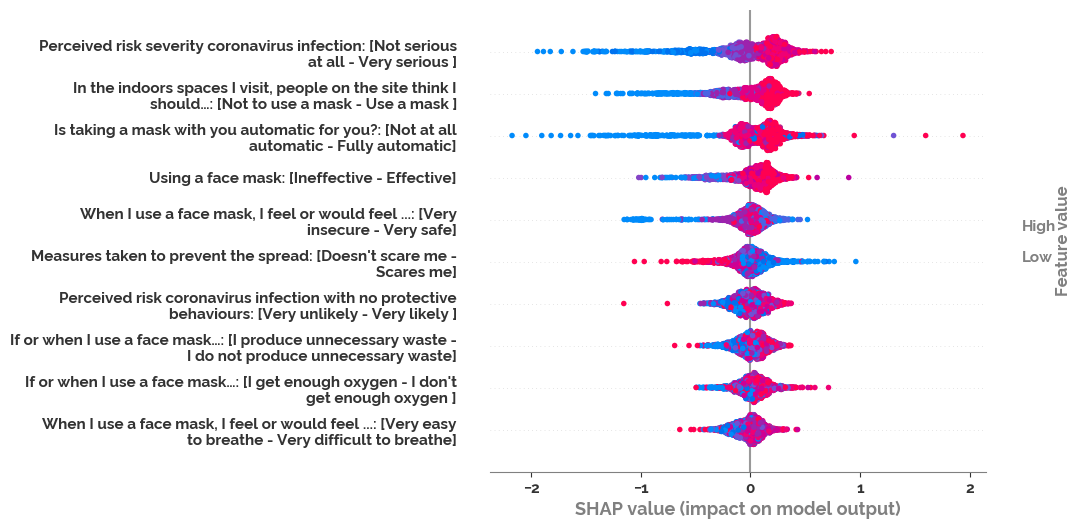

In [73]:
short_shap_plot_all.set_figheight(6)
short_shap_plot_all.set_figwidth(8)
short_shap_plot_all

In [74]:
display_length = df.shape[0]

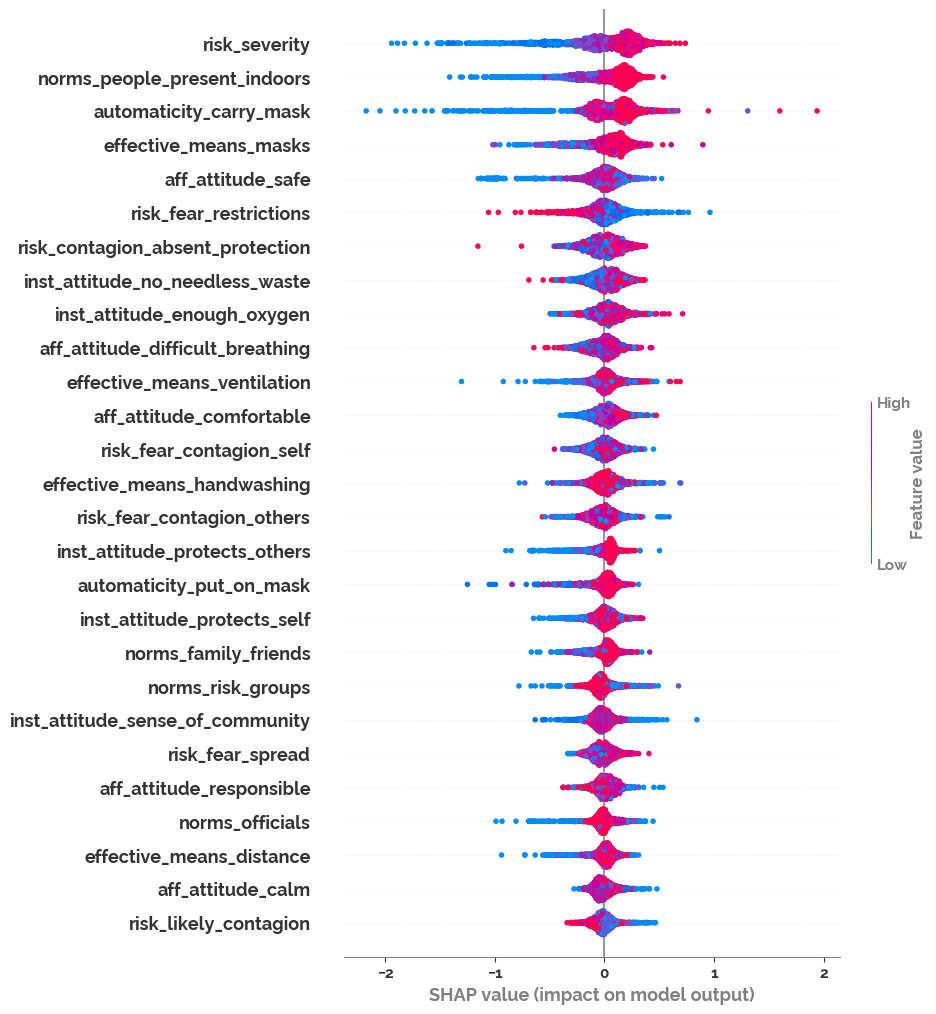

In [75]:
short_shap_plot_all = naive_catboost_shap(df = df,
                    grouping_var = grouping_var,
                    column_list = features_list,
                    plot_title="All",
                   max_display=display_length)

In [82]:
new_axis_list = pd.Series([f"{x[1]}: [{x[2]} - {x[3]}]" for x in sort_shap_long_list[:display_length]]).str.wrap(80).tolist()
new_axis_list = pd.Series([f"({x[0]}) {x[1]}: [{x[2]} - {x[3]}]" for x in sort_shap_long_list[:display_length]]).str.wrap(80).tolist()
new_axis_list.reverse()
# new_axis_list = pd.Series([x[1] for x in sort_shap_list[:display_length]]).str.wrap(61).tolist()
_ = short_shap_plot_all.gca().set_yticklabels(new_axis_list, fontsize=11)

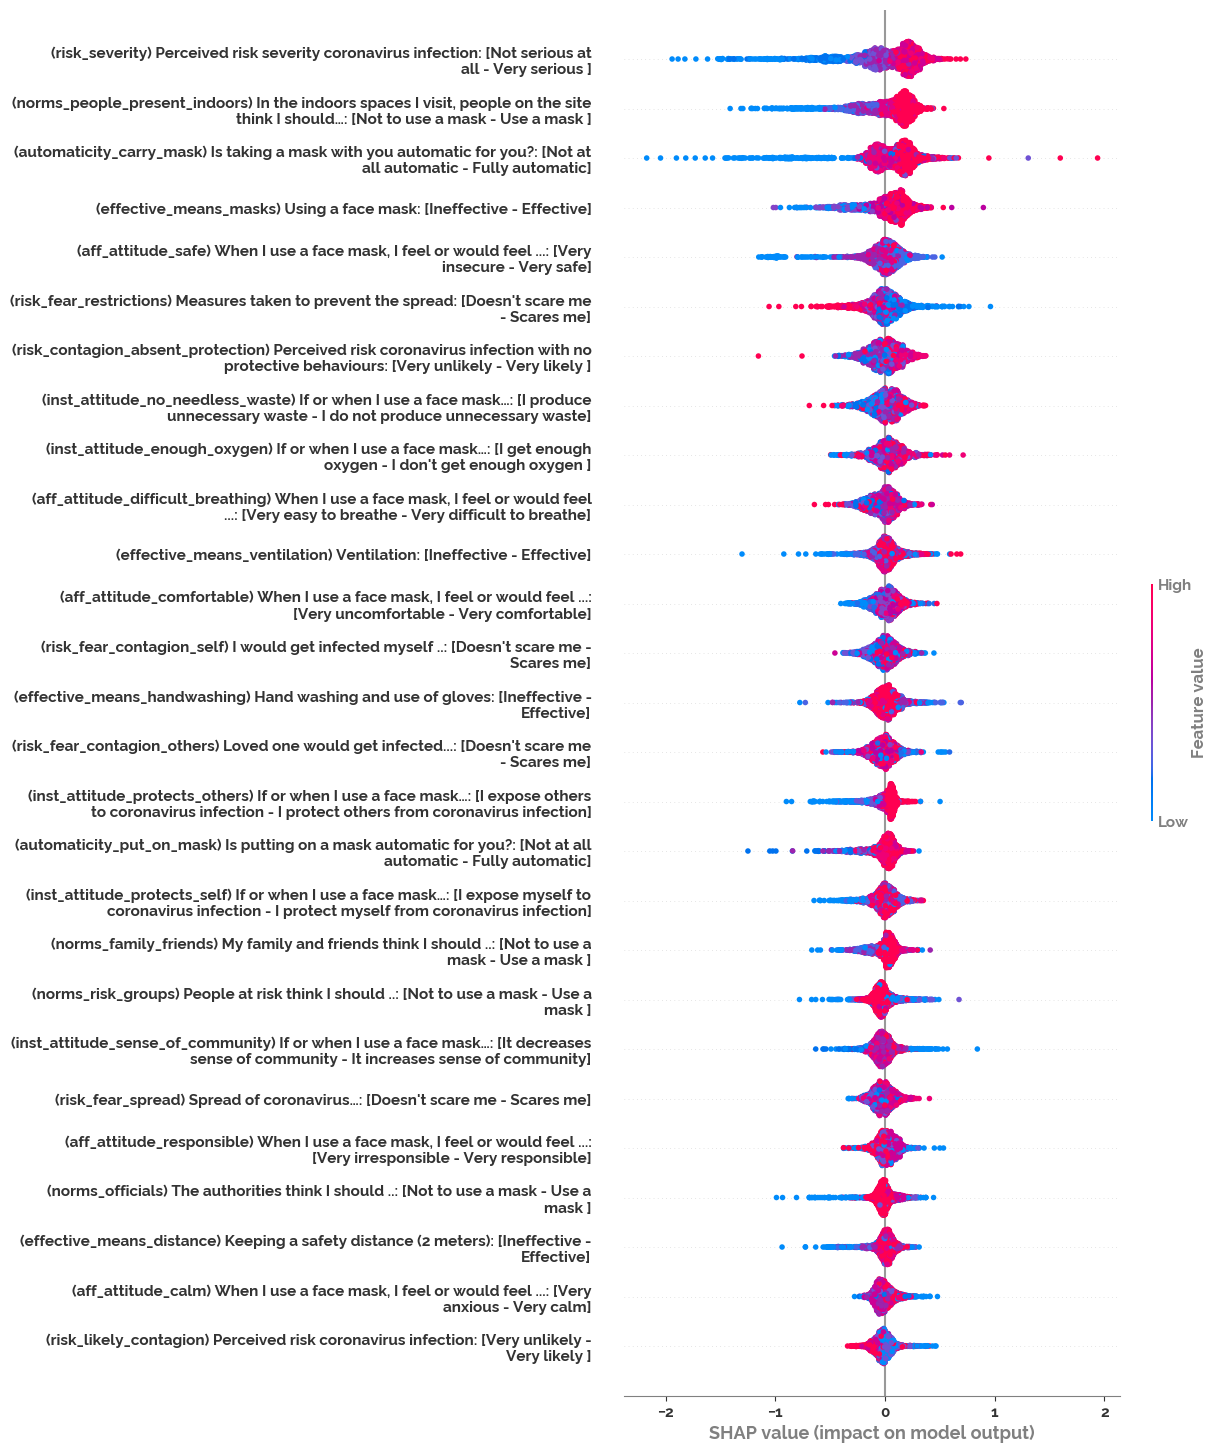

In [84]:
short_shap_plot_all.set_figheight(18)
short_shap_plot_all.set_figwidth(8)
short_shap_plot_all

In [85]:
!jupyter nbconvert --to html catboost_regression_clean.ipynb

[NbConvertApp] Converting notebook catboost_regression_clean.ipynb to html
[NbConvertApp] Writing 9656236 bytes to catboost_regression_clean.html
